# Import all libraries

First we import all libraries. In the book we start by just using numpy and pandas, however after the decision tree we start using sci-kit learn 

In [1]:
# =========================
# Core numerical and data tools
# =========================
import numpy as np
import pandas as pd
import random

# Plotting and visualization (notebook use)
import matplotlib.pyplot as plt
import seaborn as sns

# Set seeds to keep results stable every time we run the chapter
np.random.seed(15)
random.seed(15)

# =========================
# Machine learning models
# =========================
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.model_selection import KFold
# =========================
# Model selection and pipelines
# =========================
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from functools import partial

# =========================
# Evaluation metrics
# =========================
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    make_scorer
)

# =========================
# Explainability
# =========================
import shap

# =========================
# Serialization and filesystem
# =========================
import os
import json
import joblib

# =========================
# Project specific ETL
# =========================
from etl import etl_transform_for_pipeline


# Now we start! 

Each cell in the notebook will show the number of the code listing in the book. Some results in the book appear as tables or single numbers, so there is no code for them. In those cases we add a short text reference in the notebook so the reader knows what part of the book they are looking at. All the code is commented, and each cell has a small text description to help the reader follow the storyline of the book.

# Code Listing 2.1: What is this?!

Our first piece of code in the book. This is where the narrative for the decision trees chapter begins. In the book we pretend that a previous colleague wrote this before leaving the company. We then break the code into smaller pieces and study each one. The goal is to understand what this code is doing and confirm if it is really a decision tree.

In [2]:


def gini(y):
    """
    Compute the Gini impurity for a vector of class labels y.
    Lower values mean a purer node.
    """
    # Get unique class labels and how many times each appears.
    _, counts = np.unique(y, return_counts=True)

    # Convert counts to probabilities.
    probabilities = counts / counts.sum()

    # Apply the Gini formula: 1 minus the sum of squared probabilities.
    gini_impurity = 1 - np.sum(probabilities**2)

    return gini_impurity


def best_split(X, y):
    """
    Scan all features and possible thresholds and pick the split
    that gives the largest reduction in Gini impurity.
    """
    m, n = X.shape  # m is number of rows, n is number of features

    # Keep track of the best improvement in impurity seen so far.
    best_gain = -1
    best_feature = None
    best_threshold = None

    # Gini impurity of the current node before any split.
    parent_gini = gini(y)

    # Loop over every feature.
    for feature_index in range(n):

        # Pair the values of this feature with their labels, sort by feature value.
        thresholds, classes = zip(*sorted(zip(X[:, feature_index], y)))

        # Walk through the sorted labels looking for a change of class.
        for i in range(1, len(classes)):
            # A change in class means a potential split point.
            if classes[i] != classes[i - 1]:

                # Threshold is the midpoint between two consecutive feature values.
                threshold = (thresholds[i] + thresholds[i - 1]) / 2

                # Split the data according to the candidate threshold.
                left_mask = X[:, feature_index] < threshold
                right_mask = X[:, feature_index] >= threshold

                n_left, n_right = np.sum(left_mask), np.sum(right_mask)

                # If one side is empty, this is not a valid split.
                if n_left == 0 or n_right == 0:
                    continue

                # Compute Gini impurity for left and right child nodes.
                gini_left = gini(y[left_mask])
                gini_right = gini(y[right_mask])

                # Weighted average of the two impurities.
                weighted_gini = (n_left / m) * gini_left + (n_right / m) * gini_right

                # Gain is the reduction in impurity compared to the parent.
                gain = parent_gini - weighted_gini

                # Update the best split if this one is better.
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_index
                    best_threshold = threshold

    # Return the best feature index and the best threshold found.
    return best_feature, best_threshold


def build_tree(X, y, depth=0, max_depth=None):
    """
    Recursively build a decision tree.
    Each node is represented as a tuple:
    (feature_index, threshold, left_subtree, right_subtree)
    Leaf nodes have feature_index set to None and threshold equal to the predicted class.
    """
    # Stopping criterion 1
    # If we reach the maximum depth, we create a leaf with the majority class.
    if depth == max_depth or len(np.unique(y)) == 1:
        # np.bincount assumes y contains non negative integer class labels.
        most_common = np.bincount(y).argmax()
        return (None, most_common, None, None)

    # Find the best split for this node.
    feature, threshold = best_split(X, y)

    # Stopping criterion 2
    # If no valid split is found, we also create a leaf.
    if feature is None:
        most_common = np.bincount(y).argmax()
        return (None, most_common, None, None)

    # Partition the data according to the chosen feature and threshold.
    left_mask = X[:, feature] < threshold
    right_mask = X[:, feature] >= threshold

    # Recursively build the left and right subtrees, increasing the depth by one.
    left_subtree = build_tree(X[left_mask], y[left_mask], depth + 1, max_depth)
    right_subtree = build_tree(X[right_mask], y[right_mask], depth + 1, max_depth)

    # Internal node contains the splitting rule and pointers to its children.
    return (feature, threshold, left_subtree, right_subtree)


def predict(tree, x):
    """
    Walk down the tree for a single observation x and return the predicted class.
    """
    feature, threshold, left_subtree, right_subtree = tree

    # If feature is None we are at a leaf, threshold stores the class label here.
    if feature is None:
        return threshold

    # Decide whether to go left or right based on the current split.
    if x[feature] < threshold:
        return predict(left_subtree, x)
    else:
        return predict(right_subtree, x)


# Code listing 3.8: A non-recursive head calculator.

Because our decision tree code uses recursive functions, we take a small detour to understand how these functions actually work. We start with a simple example. We build a head counter without using a recursive function. This gives us a clear baseline before we bring recursion into the picture.

In [3]:
def simulate_hydra_non_recursive(lost_heads, regrowth_factor=2, generations=3):
    """
    Simulate Hydra head regrowth without using recursion.
    This helps us understand the basic idea before we introduce recursive functions.

    Parameters
    lost_heads: number of heads the Hydra loses in the first event
    regrowth_factor: how many heads grow back for every head lost
    generations: how many waves of regrowth we want to simulate

    The model is simple. If the Hydra loses some heads, it regrows new ones.
    Those new heads can then regrow even more in the next generation, and so on.
    We sum all the heads produced across the generations to get the final count.
    """

    # Track how many heads the Hydra produces across all generations.
    total_heads = 0

    # First generation of regrowth.
    # We multiply the initial lost heads by the regrowth factor.
    # This tells us how many heads appear immediately.
    current_heads = lost_heads * regrowth_factor

    # Now we loop through the number of generations we want to simulate.
    for _ in range(generations):

        # Add the current generation of heads to the total.
        total_heads += current_heads

        # Prepare the head count for the next generation.
        # Each head now produces more heads again using the same factor.
        current_heads *= regrowth_factor

    # At the end we return how many heads the Hydra grew across all generations.
    return total_heads


## How many heads?

In [4]:
simulate_hydra_non_recursive(1, regrowth_factor=2, generations=3)

14

# Code listing 3.9: A recursive head calculator.

Now we repeat the same head calculation, but this time we use a recursive function. This lets us compare both approaches and see how recursion builds the result step by step.

In [5]:
def simulate_hydra_recursive(lost_heads, regrowth_factor=2, generation=0, max_generations=3):
    """
    A recursive version of the Hydra head simulation.
    This mirrors the previous example but now we let the function call itself.
    The idea is simple. Each call handles one generation of regrowth and
    then passes the newly grown heads to the next call, until we reach the end.

    Parameters
    lost_heads: heads lost in the current generation
    regrowth_factor: how many heads grow for every head lost
    generation: which regrowth cycle we are in
    max_generations: total cycles to simulate
    """

    # Base case.
    # If we have completed all the allowed generations, or there are no heads to grow,
    # we stop the recursion and return zero from this branch.
    if generation == max_generations or lost_heads == 0:
        return 0

    # First we compute how many heads appear in this generation.
    next_heads = lost_heads * regrowth_factor

    # The magic of recursion.
    # We return the heads from this generation plus
    # whatever the next generations produce.
    # The function calls itself, with updated values, to simulate the next cycle.
    return next_heads + simulate_hydra_recursive(
        next_heads,
        regrowth_factor,
        generation + 1,
        max_generations
    )


## Hit me. Not physically. It is just blackjack lingo.

In [6]:
simulate_hydra_recursive(1, regrowth_factor=2, generation=0, max_generations=3)

14

# Code listing 3.11: Frankie is that you?

Here is where the machine learning starts. We load the data and get everything ready to run the tree.

In [7]:
data = pd.read_csv('section_1_risk_dataset.csv')                 

In [8]:
data.columns

Index(['customer_id', 'creature_type', 'flight_status',
       'dance_disaster_rating', 'ticklish_level', 'eyesight', 'age',
       'number_of_policies', 'fire_power_level', 'soda_likeness_rate',
       'snack_obsession', 'creature_cost', 'hearing_score',
       'rage_outburst_score', 'risk'],
      dtype='object')

# Code listing 3.12: Already to Numpy?

Now we will split our data: X will have our features and y our labels.

In [9]:
# Select the features for the model.
# We drop the target column risk along with a few columns
# that we do not want the tree to use. These include the creature type,
# the flight status, and the customer id. What remains is the feature matrix X.
X = data.drop(['risk'], axis=1).values

# Extract the risk column as our target vector y.
y = data['risk'].values


# Code listing 3.14: Tell us how many please. We need to know!

It is time to see how well the decision tree performs, so we create a function that computes the accuracy.

In [10]:
def calculate_accuracy(y_true, y_pred):
    """
    Compute the accuracy of our decision tree.
    We compare the predicted labels with the true labels
    and count how many times the model gets it right.
    The result is the proportion of correct predictions.
    """
    return np.sum(y_true == y_pred) / len(y_true)


# Code listing 3.15: Grow for us papa tree!

Run time papy!

In [11]:
# Build the tree using all the training data.
tree = build_tree(X, y)

# Run the tree on every observation in X.
# We collect all predictions in a single array.
predictions = np.array([predict(tree, xi) for xi in X])

# Compute how often the model gets the label right.
accuracy = calculate_accuracy(y, predictions)

# Display the result to see how well our home made tree performs.
print("Accuracy:", accuracy)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

# Code listing 3.17: Come out voluntarily; consequences will be severe if we find you first.

Because the code crashed, we need to investigate what went wrong. Our first step is to check if any of the features still contain strings.

In [12]:
''' Loop through each column in the dataset and check if at least one value is a string.
    If we find strings, we print the column name'''

for col in data.columns:
    if data[col].apply(lambda x: isinstance(x, str)).any():
        print(f"Column '{col}' contains string values.")



Column 'customer_id' contains string values.
Column 'creature_type' contains string values.
Column 'flight_status' contains string values.


# Code listing 3.18: Are there any NaN's in the house?

Now we check for missing values. Our tree code does not know how to handle NaN values, so we need to identify which columns contain them.

In [13]:
# -------------------------------------------------------------
#  The isna method returns
# a boolean mask, and we filter it to show only the columns that
# actually have missing entries.
# -------------------------------------------------------------
nan_columns = data.isna().any()
print(nan_columns[nan_columns == True])


creature_type         True
number_of_policies    True
dtype: bool


# Code listing 3.19: Show your face NaN's!

We need to take a closer  look at the number_of_policies column. So we will count how many missing values it has. This helps us decide
how to handle the NaNs before passing the data to our tree.

In [14]:
# -------------------------------------------------------------
# Count how many missing values exist in the number_of_policies column.
# The isna method marks each missing entry, and sum adds them up.
# -------------------------------------------------------------
nan_count_in_column_number_of_policies = data['number_of_policies'].isna().sum()
print("Number of NaNs in column 'number_of_policies':", nan_count_in_column_number_of_policies)


Number of NaNs in column 'number_of_policies': 1789


# Table 3.11: How number_of_policies is behaving

In [15]:
# -------------------------------------------------------------
# Compute basic statistics for the number_of_policies column.
# Each method automatically ignores NaN values.

# The minimum value in the column.
min_value = data['number_of_policies'].min()

# The maximum value in the column.
max_value = data['number_of_policies'].max()

# The average value of the column.
mean_value = data['number_of_policies'].mean()

# The standard deviation of the column.
# ddof=0 means we use the population formula.
std_deviation = data['number_of_policies'].std(ddof=0)

# Print the four statistics so we can inspect them directly.
print("Minimum:", min_value)
print("Maximum:", max_value)
print("Mean:",  np.round(mean_value, 3) )
print("Standard Deviation:", np.round(std_deviation,3))


Minimum: 1.0
Maximum: 20.0
Mean: 10.488
Standard Deviation: 5.798


# Figure 3.16: They all show up the same number of times.

Because the number_of_policies feature contains NaN values, we need to decide how to replace them. Our first step is to plot a histogram and study how this feature behaves.

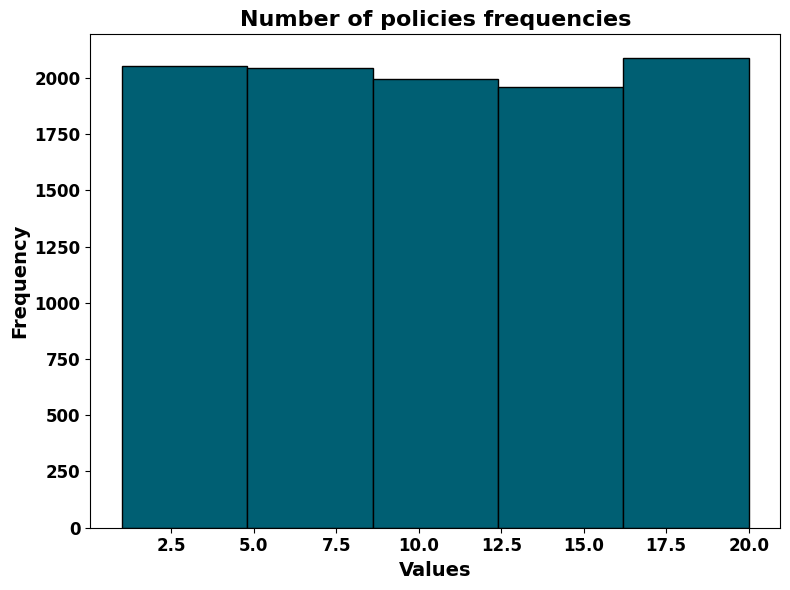

In [16]:
# -------------------------------------------------------------
# Create a histogram for the number_of_policies feature.
# -------------------------------------------------------------

# Set the size of the figure.
plt.figure(figsize=(8, 6))

# Plot the histogram with five bins.
# NaN values are ignored by default.
data['number_of_policies'].hist(bins=5, color='#005F73', edgecolor='black')

# Label the axes and title for clarity.
plt.xlabel('Values', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Number of policies frequencies', fontsize=16, fontweight='bold')

# Format the tick labels.
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Remove the grid for a cleaner look.
plt.grid(False)

# Adjust layout so nothing overlaps.
plt.tight_layout()


# Display the plot.
plt.show()


## A note on code listing 3.20 and 3.21

These listings are in the book mainly to introduce bad practices and therefore will not be present here in the notebook. If you wish to copy them and run the code to perfectly emulate the book we need to speak about that random seed. When you introduce even a single extra random call the entire stream shifts and every number that follows changes. This means that the results will not match unless the sequence of operations is identical. Once the stream changes there is no clean way to force it back, so the only correct path is to accept the new sequence or replicate every step exactly as it appears in the book.

This also means if the cells are not ran in the same order results will differ.

It might be the case that the results change in a way where for example the random forest performs worse than the decision tree. Please keep in mind that I generated these datasets and as you will see the results change but not by much. In reality random forest and gradient boosted trees tend to outperform a single tree. The reason for the search of this specific story line where at least one of the most complex tree based models outperforms the decision tree was for motivation porpouses. We will make some effort to learn something that can help us and they do. So let us leave the disappointment to when you apply these models in real data :) 

### Lets also count the number of NaN's in the creature_type:

In [17]:
nan_count_in_column_creature_type = data['creature_type'].isna().sum()
print("Number of NaNs in column 'creature_type':", nan_count_in_column_creature_type)


Number of NaNs in column 'creature_type': 119


# Figure 3.17: They all show up the same number of times.

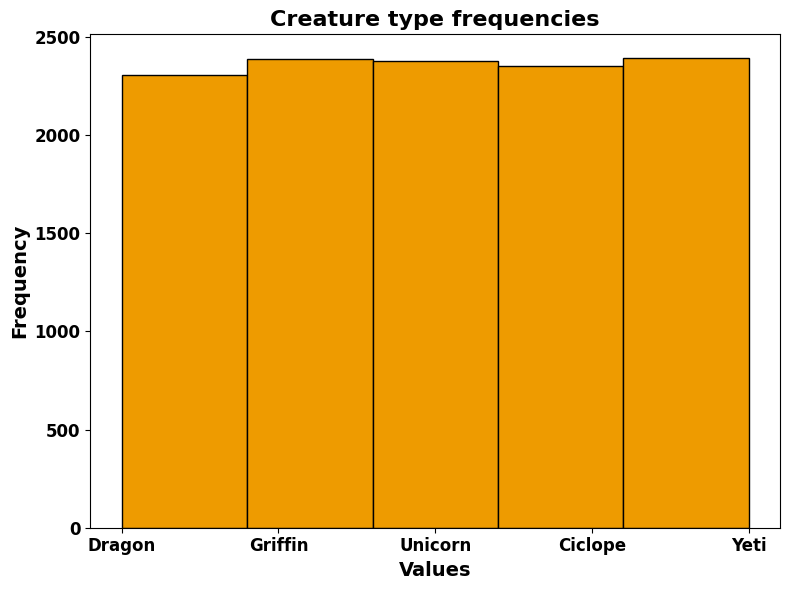

In [18]:
# -------------------------------------------------------------
# Create a histogram for the creature_type column.
# This lets us see how often each creature appears in the dataset.
# Even though creature_type is a categorical feature, pandas will
# still produce a histogram by counting each category.
# -------------------------------------------------------------

plt.figure(figsize=(8, 6))

# Plot the histogram with five bins. Each bin groups creature types
# so we get a sense of their distribution.
data['creature_type'].hist(bins=5, color='#EE9B00', edgecolor='black')

# Label the axes and add a title.
plt.xlabel('Values', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Creature type frequencies', fontsize=16, fontweight='bold')

# Format the tick labels.
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Remove the grid for a cleaner visual.
plt.grid(False)

# Adjust layout to avoid label overlap.
plt.tight_layout()

# Display the histogram.
plt.show()


# Code listing 3.22: The slash and dice of the feature set.

Yes, training and testing on the same data is cheating. So we need a routine to split our dataset. This gives us a separate set that the model has never seen before, which is a much better reflection of what happens in the real world.

In [19]:
def train_test_split_(X, y, test_size=0.25, random_state=42):
    # Convert the feature matrix to a NumPy array.
    # This ensures that indexing and slicing behave in a predictable way.
    X = np.asarray(X)

    # Convert the target vector to a NumPy array and cast it to integers.
    # Some datasets store labels as object types so this ensures consistency.
    y = np.asarray(y).astype(int)

    # Count how many samples the dataset contains.
    n = len(X)

    # Create a random number generator with a fixed seed.
    # This produces the same shuffling every time, which ensures reproducibility.
    rng = np.random.RandomState(random_state)

    # Create a random permutation of all sample indices.
    # Each index appears once and the order is fully shuffled.
    idx = rng.permutation(n)

    # Compute how many samples should go into the test set.
    # For example, with a test size of 0.25 we send twenty five percent of the data to the test set.
    n_test = int(round(n * test_size))

    # Select the first part of the shuffled indices as the test indices.
    test_idx = idx[:n_test]

    # The remaining indices form the training set.
    train_idx = idx[n_test:]

    # Return the training features, test features, training labels, and test labels.
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]


# Code listing 3.23: Slice and dice those sets.

We now know what data leakage is, so in this next listing we do things properly. First we compute the metrics to replace the NaN values on the training set. Then we use those same metrics to fill the NaN entries in the test set. This way we emulate a real world scenario where these values are already stored, and each time a new NaN appears we can replace it with our precomputed numbers.

In [20]:
# -------------------------------------------------------------
# Build the feature matrix X and the target vector y.
# We drop the risk column (our target), the risk_score,
# and the categorical features creature_type and flight_status,
# along with the customer_id. What remains in X are the numeric
# features that will feed the decision tree.
# -------------------------------------------------------------
X = data.drop(['risk', 'creature_type', 'flight_status', 'customer_id'], axis=1)
y = data['risk']

# Keep a copy of the column names so we can rebuild DataFrames later.
columns = X.columns

# -------------------------------------------------------------
# Split the data into training and test sets.
# The custom train_test_split function returns NumPy arrays,
# so X_train_arr and X_test_arr are arrays rather than DataFrames.
# -------------------------------------------------------------
X_train_arr, X_test_arr, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=15
)

# -------------------------------------------------------------
# Convert the training and test feature arrays back into DataFrames.
# We reattach the original column names so we can refer to features
# by name when we perform the imputation step.
# -------------------------------------------------------------
X_train = pd.DataFrame(X_train_arr, columns=columns)
X_test = pd.DataFrame(X_test_arr, columns=columns)

# -------------------------------------------------------------
# Imputation step using only the training set.
# We extract the number_of_policies column from the training data
# and compute its minimum and maximum values.
# These two numbers define the range we use to fill NaN entries.
# -------------------------------------------------------------
train_policies = X_train["number_of_policies"]
min_pol = train_policies.min()
max_pol = train_policies.max()

# -------------------------------------------------------------
# Replace NaN values in the training set.
# If an entry in number_of_policies is NaN, we draw a random
# integer between min_pol and max_pol (inclusive).
# If it is not NaN, we convert the value to an integer.
# -------------------------------------------------------------
X_train["number_of_policies"] = X_train["number_of_policies"].apply(
    lambda x: np.random.randint(min_pol, max_pol + 1) if pd.isna(x) else int(x)
)

# -------------------------------------------------------------
# Apply the same imputation logic to the test set.
# The important detail is that we reuse min_pol and max_pol
# computed from the training set. In a real world scenario,
# these values would be stored from the training phase and
# applied later to new incoming data.
# -------------------------------------------------------------
X_test["number_of_policies"] = X_test["number_of_policies"].apply(
    lambda x: np.random.randint(min_pol, max_pol + 1) if pd.isna(x) else int(x)
)

# -------------------------------------------------------------
# Finally, convert the cleaned DataFrames back to NumPy arrays.
# Our decision tree implementation expects X to be an array.
# -------------------------------------------------------------
X_train = X_train.values
X_test = X_test.values

# Code listing 3.24: The moment of truth.

Time to run our tree with the train and test split and no leakage!

In [21]:
# -------------------------------------------------------------
# Build the decision tree using only the training data.
# The tree has never seen the test set, which means no leakage.
# -------------------------------------------------------------
tree = build_tree(X_train, y_train)

# -------------------------------------------------------------
# Generate predictions for every observation in the test set.
# We walk each test sample through the tree and collect the outputs.
# -------------------------------------------------------------
predictions = np.array([predict(tree, xi) for xi in X_test])

# -------------------------------------------------------------
# Measure how often these predictions match the true test labels.
# This gives us the accuracy of the model on unseen data.
# -------------------------------------------------------------
accuracy = calculate_accuracy(y_test, predictions)

# -------------------------------------------------------------
# Print the test accuracy so we can evaluate the tree properly.
# -------------------------------------------------------------
print("Accuracy with no categorical features:", np.round(accuracy,3))


Accuracy with no categorical features: 0.624


# Code listing 3.25: How many of each?

We will count how many entries per label we have.

In [22]:
# -------------------------------------------------------------
# value_counts gives the counts, and reset_index converts the result
# into a DataFrame. We then rename the columns to Risk Type and Frequency.
# -------------------------------------------------------------
risk_counts = data['risk'].value_counts().reset_index()
risk_counts.columns = ['Risk Type', 'Frequency']
risk_counts

,Risk Type,Frequency
0,1,5966
1,0,5966


# Code listing 3.26: How many of you do we have?

We are about to start our encoding journey, and the first step is to check the unique values in each of our categorical features.

In [23]:
unique_values_ct = data['creature_type'].unique()
unique_values_fs = data['flight_status'].unique()

print("Unique values for creature type", unique_values_ct)
print("Unique values for flight status",unique_values_fs)

Unique values for creature type ['Dragon' 'Griffin' 'Unicorn' 'Ciclope' 'Yeti' nan]
Unique values for flight status ['Yes' 'No']


# Code listing 3.27: Another time the Panda helps us.

In [24]:
# Remove the target, the score, and the identifier from the dataset.
# The remaining columns form the feature matrix.
# We keep the categorical fields creature_type and flight_status because we will encode them later.
X_enc = data.drop(['risk', 'customer_id'], axis=1)

# Extract the target variable as a separate Series.
y_enc = data['risk']

# Save the original column order so we can restore it after splitting.
columns = X_enc.columns

# Perform the train test split.
# The function returns NumPy arrays, not DataFrames, which is why we convert back below.
X_train_arr, X_test_arr, y_train, y_test = train_test_split(
    X_enc, y_enc, test_size=0.3, random_state=15
)

# Convert the NumPy arrays back into DataFrames to keep column names and allow easy manipulation.
X_train_enc = pd.DataFrame(X_train_arr, columns=columns)
X_test_enc = pd.DataFrame(X_test_arr, columns=columns)

# Create untouched copies so we can compare the encoded and unencoded versions later if needed.
X_train_enc_un = X_train_enc.copy()
X_test_enc_un = X_test_enc.copy()

# Impute missing values in number_of_policies with a random integer in the valid range.
# This applies only when the value is NaN. Otherwise we cast the existing value to an integer.
X_train_enc["number_of_policies"] = X_train_enc["number_of_policies"].apply(
    lambda x: np.random.randint(min_pol, max_pol + 1) if pd.isna(x) else int(x)
)

X_test_enc["number_of_policies"] = X_test_enc["number_of_policies"].apply(
    lambda x: np.random.randint(min_pol, max_pol + 1) if pd.isna(x) else int(x)
)

# For the categorical field creature_type we draw random replacements only from the set of valid types in the training set.
# This prevents leakage because the model should not learn categories from the test set during imputation.
train_types = X_train_enc["creature_type"].dropna().unique()

X_train_enc["creature_type"] = X_train_enc["creature_type"].apply(
    lambda x: np.random.choice(train_types) if pd.isna(x) else x
)

X_test_enc["creature_type"] = X_test_enc["creature_type"].apply(
    lambda x: np.random.choice(train_types) if pd.isna(x) else x
)

# One hot encode the two categorical columns.
# drop_first removes one level from each category to avoid collinearity with the intercept.
X_train_enc = pd.get_dummies(
    X_train_enc, columns=['creature_type', 'flight_status'], drop_first=True, dtype=int
)

X_test_enc = pd.get_dummies(
    X_test_enc, columns=['creature_type', 'flight_status'], drop_first=True, dtype=int
)

# Align the training and test sets to have exactly the same columns.
# Any column missing in the test set will be added with zeros.
X_test_enc = X_test_enc.reindex(columns=X_train_enc.columns, fill_value=0)

# Convert the final DataFrames into NumPy arrays for the model.
X_train_enc_v = X_train_enc.values
X_test_enc_v = X_test_enc.values


# Code listing 3.28

In [25]:
# Train the decision tree using the encoded training data.
# X_train_enc_v contains the feature matrix as a NumPy array.
# y_train contains the corresponding labels.
tree = build_tree(X_train_enc_v, y_train)

# Generate predictions for the test set.
# We loop through each test sample and pass it to the predict function.
# The result is collected into a NumPy array for easy evaluation.
predictions = np.array([predict(tree, xi) for xi in X_test_enc_v])

# Compute the accuracy by comparing predicted labels with the true labels.
# The function calculate_accuracy returns the fraction of correct predictions.
accuracy = calculate_accuracy(y_test, predictions)

# Display the final accuracy score.
print("Accuracy with categorical features:", np.round(accuracy,3))

Accuracy with categorical features: 0.639


# Code listing 3.9: You wouldn't be folding this much if it were laundry.

It is time we experiment with a new evaluation method, the k fold cross validation. Here we compute several performance metrics, in this case accuracies, and then average them for a final result.

In [26]:
def k_fold_cross_validation(X, y, k=5, scorer=None, max_depth_v=None):
    # Make sure we work with NumPy arrays for consistent positional indexing
    X = np.asarray(X)
    y = np.asarray(y).astype(int)

    # Count how many samples we have in the dataset.
    n = len(X)

    # Create a random permutation of all sample indices.
    # This ensures the folds are shuffled before splitting.
    indices = np.random.permutation(n)

    # Split the shuffled indices into k roughly equal sized folds.
    folds = np.array_split(indices, k)

    # This list will store the score from each fold.
    scores = []

    # Loop through each fold and treat it as the test set.
    for test_idx in folds:
        # All other samples become the training set.
        train_idx = np.setdiff1d(indices, test_idx)

        # Build a decision tree on the training subset.
        model = build_tree(X[train_idx], y[train_idx], max_depth=max_depth_v)

        # Predict the labels for the current test fold.
        y_pred = np.array([predict(model, xi) for xi in X[test_idx]])

        # Compute the score for this fold.
        scores.append(scorer(y[test_idx], y_pred))

    # Return the list of scores, one per fold.
    return scores


We now need to perform two k fold cross validation runs, one for each training setup we have. This gives us an evaluation on the set with no categorical variables and on the set that includes them.

## K-fold cross valitation with no categorical variables

In [27]:
k = 5
scores = k_fold_cross_validation(X_train, y_train, k, scorer = calculate_accuracy)
scores = np.round(scores, 3)

print("Accuracy values and mean accuracy after k fold cross validation without categorical variables:")
print("Accuracies:", scores)
print("Mean accuracy:", np.round(np.mean(scores), 3))

Accuracy values and mean accuracy after k fold cross validation without categorical variables:
Accuracies: [0.637 0.637 0.632 0.623 0.647]
Mean accuracy: 0.635


## K-fold cross valitation with categorical variables

In [28]:
k = 5
scores = k_fold_cross_validation(X_train_enc_v, y_train, k, scorer = calculate_accuracy)
scores = np.round(scores, 3)

print(
    "The same metrics as above but now for a model cross validated with no categorical variables, along with the mean accuracy after the k fold cross validation:",
)
print("Accuracies:", scores)
print("Mean accuracy:", np.round(np.mean(scores), 3))

The same metrics as above but now for a model cross validated with no categorical variables, along with the mean accuracy after the k fold cross validation:
Accuracies: [0.629 0.649 0.641 0.626 0.654]
Mean accuracy: 0.64


# Figure 3.20: Is this a crocodile's mount?

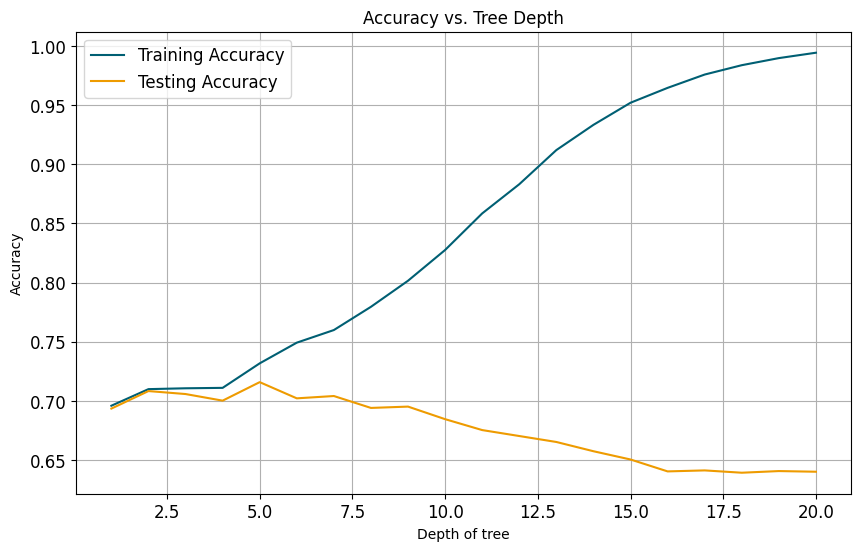

In [29]:
# Define the range of tree depths we want to evaluate.
# This allows us to see how shallow and deep trees perform.
depths = range(1, 21)

# Lists where we store the accuracy scores for each depth.
train_accuracies = []
test_accuracies = []

# Convert labels to integers. The build_tree function uses np.bincount,
# which requires integer inputs.
y_train_int = np.asarray(y_train, dtype=int)
y_test_int = np.asarray(y_test, dtype=int)

# Loop over each candidate depth.
for depth in depths:
    # Train a tree with the given maximum depth.
    tree = build_tree(X_train_enc_v, y_train_int, max_depth=depth)

    # Generate predictions for both the training set and testing set.
    train_pred = np.array([predict(tree, xi) for xi in X_train_enc_v])
    test_pred  = np.array([predict(tree, xi) for xi in X_test_enc_v])

    # Compute the accuracy for the training set.
    train_accuracies.append(calculate_accuracy(y_train_int, train_pred))

    # Compute the accuracy for the testing set.
    test_accuracies.append(calculate_accuracy(y_test_int, test_pred))

# Plot the results to visualise how accuracy changes with tree depth.
plt.figure(figsize=(10, 6))

# Training accuracy curve.
plt.plot(list(depths), train_accuracies, label='Training Accuracy', color="#005F73")

# Testing accuracy curve.
plt.plot(list(depths), test_accuracies, label='Testing Accuracy', color="#EE9B00")

# Labels and title.
plt.xlabel('Depth of tree')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Tree Depth')

# Add legend and adjust styling.
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)


plt.show()


## A quick experimentation with the max_depth parameter.

This is where we do our first quick experiment with cross validation and the max_depth parameter. One of our goals is to check for overfitting, so we will make a small change to our k_fold_cross_validation function. We now want to record the results of each fold both on the validation set and on the training set.

In [30]:
def k_fold_cross_validation_train(X, y, k=5, scorer=None, max_depth_v=None):
    # Count the number of samples in the dataset.
    n = len(X)
    X = np.asarray(X)
    y = np.asarray(y).astype(int)

    # Create a random permutation of all sample indices.
    # This shuffles the dataset before it is divided into folds.
    indices = np.random.permutation(n)

    # Split the shuffled indices into k equally sized folds.
    folds = np.array_split(indices, k)

    # Lists to store the accuracy scores for the validation set and the training set.
    val_scores = []
    train_scores = []

    # Loop through each fold, treating it as the validation fold.
    for test_idx in folds:
        # All indices not in the current validation fold become the training indices.
        train_idx = np.setdiff1d(indices, test_idx)

        # Train a decision tree on the training portion of the current split.
        model = build_tree(X[train_idx], y[train_idx], max_depth=max_depth_v)
        
        # Predict on the validation fold.
        y_val_pred = np.array([predict(model, xi) for xi in X[test_idx]])
        # Compute the validation accuracy and store it.
        val_scores.append(scorer(y[test_idx], y_val_pred))
        
        # Predict on the training portion.
        y_train_pred = np.array([predict(model, xi) for xi in X[train_idx]])
        # Compute the training accuracy and store it.
        train_scores.append(scorer(y[train_idx], y_train_pred))

    # Return both accuracy lists so we can compare training and validation performance.
    return val_scores, train_scores


## Check for overfit with max_depth = 5 and cross validation

In [31]:
val_scores, train_scores = k_fold_cross_validation_train(X_train_enc_v, y_train, k, scorer=calculate_accuracy, max_depth_v=5)

print("Accuracy values and mean accuracy after k fold cross validation with max_depth = 5:")
print("Mean accuracy for test set:", np.round(np.mean(val_scores), 3))
print("Mean accuracy for the training set:", np.round(np.mean(train_scores), 3))


Accuracy values and mean accuracy after k fold cross validation with max_depth = 5:
Mean accuracy for test set: 0.719
Mean accuracy for the training set: 0.734


# Code listing 3.32: Those juicy nodes, we are coming for you!

Because our original decision tree code did not include all the parameters we want to study, we now have to repeat the decision tree code, each time adding the corresponding changes so it can support the new parameters.

In [32]:
import numpy as np  # assuming this is present (needed for np.unique, etc.)

def gini(y):
    # Get unique labels and their counts
    _, counts = np.unique(y, return_counts=True)
    # Compute class probabilities
    probabilities = counts / counts.sum()
    # Gini impurity = 1 - sum(p_i^2)
    gini_impurity = 1 - np.sum(probabilities**2)
    return gini_impurity

def best_split(X, y):
    # m = number of samples, n = number of features
    m, n = X.shape
    # Edge case: no samples
    if m == 0:
        return None, None
    # Track the best information gain found
    best_gain = 0
    best_feature = None
    best_threshold = None
    # Try every feature
    for feature_index in range(n):
        # Sort feature values together with their labels
        thresholds, classes = zip(*sorted(zip(X[:, feature_index], y)))
        # Evaluate possible split points
        for i in range(1, len(classes)):
            # Only consider splits where the class changes (potential improvement)
            if classes[i] != classes[i - 1]:
                # Use midpoint as the threshold
                threshold = (thresholds[i] + thresholds[i - 1]) / 2
                # Masks for left and right subsets
                left_mask = X[:, feature_index] < threshold
                right_mask = X[:, feature_index] >= threshold
                # Count samples on each side
                n_left, n_right = np.sum(left_mask), np.sum(right_mask)
                # Skip if split would create an empty subset
                if n_left == 0 or n_right == 0:
                    continue
                # Gini impurity for left and right children
                gini_left = gini(y[left_mask])
                gini_right = gini(y[right_mask])
                # Weighted average of child impurities
                weighted_gini = (n_left / m) * gini_left + (n_right / m) * gini_right
                # Information gain = parent Gini - weighted child Gini
                gain = gini(y) - weighted_gini
                # Update best split if this gain is higher
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_index
                    best_threshold = threshold
    # Return the best feature and threshold found (or None if no valid split)
    return best_feature, best_threshold

def build_tree(X, y, depth=0, max_depth=None, min_samples_split=2):
    num_samples = y.size
    # Stopping conditions: too few samples or max depth reached
    if num_samples < min_samples_split or depth == max_depth:
        # Leaf node: return most common class
        most_common = np.bincount(y).argmax()
        return (None, most_common, None, None)
    # Find the best split for current node
    feature, threshold = best_split(X, y)
    # If no valid split found, make a leaf with majority class
    if feature is None:
        return (None, np.bincount(y).argmax(), None, None)
    # Create masks for left and right subsets
    left_mask = X[:, feature] < threshold
    right_mask = X[:, feature] >= threshold
    # Recursively build left subtree
    left_subtree = build_tree(X[left_mask], y[left_mask], depth + 1, max_depth, min_samples_split)
    # Recursively build right subtree
    right_subtree = build_tree(X[right_mask], y[right_mask], depth + 1, max_depth, min_samples_split)
    # Return internal node: (feature, threshold, left, right)
    return (feature, threshold, left_subtree, right_subtree)

def predict(tree, x):
    # Unpack node
    feature, threshold, left_subtree, right_subtree = tree
    # Leaf node: feature is None, threshold holds the class label
    if feature is None:
        return threshold # here threshold holds the class label
    # Traverse left if feature value < threshold
    if x[feature] < threshold:
        return predict(left_subtree, x)
    # Otherwise traverse right
    else:
        return predict(right_subtree, x)

# Figure 3.21: Unfortunately, it seems like blue and yellow don't get along.

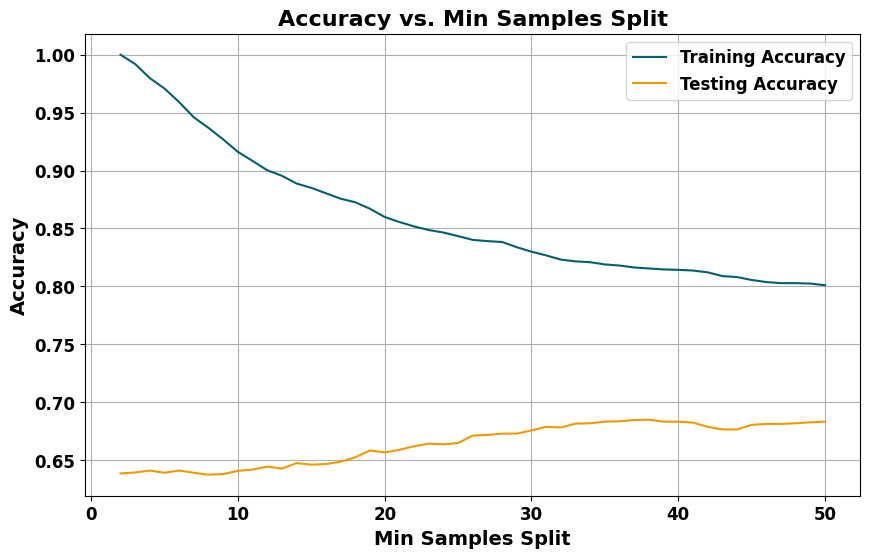

In [33]:
# Define the range of min_samples_split values to test.
# This parameter controls the minimum number of samples required to split a node.
splits = range(2, 51)

# Lists that will store the training and testing accuracies for each value of min_samples_split.
train_accuracies = []
test_accuracies = []

# Convert labels to integers. The build_tree function uses np.bincount, which requires integer inputs.
y_train_int = np.asarray(y_train, dtype=int)
y_test_int = np.asarray(y_test, dtype=int)

# Loop through all candidate values of min_samples_split.
for min_split in splits:

    # Build a decision tree with the current value of min_samples_split.
    # We keep max_depth=None so the tree can grow as deep as splitting allows.
    tree = build_tree(
        X_train_enc_v, y_train_int,
        max_depth=None,
        min_samples_split=min_split
    )

    # Predict on the entire training set to measure how well the tree fits the training data.
    train_pred = np.array([predict(tree, xi) for xi in X_train_enc_v])

    # Predict on the test set to measure generalisation performance.
    test_pred = np.array([predict(tree, xi) for xi in X_test_enc_v])

    # Compute the accuracy on training and testing sets and store them.
    train_accuracies.append(calculate_accuracy(y_train_int, train_pred))
    test_accuracies.append(calculate_accuracy(y_test_int, test_pred))

# Now we visualise how accuracy changes as min_samples_split increases.
plt.figure(figsize=(10, 6))

# Training curve in blue.
plt.plot(list(splits), train_accuracies, label='Training Accuracy', color="#005F73")

# Testing curve in orange.
plt.plot(list(splits), test_accuracies, label='Testing Accuracy', color="#EE9B00")

# Label the axes and title with larger, bold text.
plt.xlabel('Min Samples Split', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.title('Accuracy vs. Min Samples Split', fontsize=16, fontweight='bold')

# Style tick labels to make them easier to read.
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Style the legend text.
legend = plt.legend(fontsize=12)
for text in legend.get_texts():
    text.set_fontweight('bold')

# Add a grid to show trends clearly.
plt.grid(True)

plt.show()


## The last time we change our decision tree code 

In [34]:
def gini(y):
    # Compute the Gini impurity for a set of class labels y.

    # Count the occurrences of each unique class.
    _, counts = np.unique(y, return_counts=True)

    # Convert counts to class probabilities.
    probabilities = counts / counts.sum()

    # Gini impurity is one minus the sum of squared probabilities.
    gini_impurity = 1 - np.sum(probabilities**2)

    return gini_impurity


def best_split_hyper(X, y, min_samples_leaf):
    # Find the best feature and threshold to split the node while enforcing min_samples_leaf.

    # m = number of samples, n = number of features.
    m, n = X.shape

    # Initialise tracking variables for the best impurity gain and split point.
    best_gain = -1
    best_feature = None
    best_threshold = None

    # Loop over every feature.
    for feature_index in range(n):

        # Sort feature values with corresponding labels.
        thresholds, classes = zip(*sorted(zip(X[:, feature_index], y)))

        # Try split points between adjacent samples.
        for i in range(1, len(classes)):

            # Only consider a split where the class label changes.
            if classes[i] != classes[i - 1]:

                # Compute midpoint between two consecutive feature values.
                threshold = (thresholds[i] + thresholds[i - 1]) / 2

                # Create masks for left and right subsets.
                left_mask = X[:, feature_index] < threshold
                right_mask = X[:, feature_index] >= threshold

                # Enforce min_samples_leaf on both sides of the split.
                if np.sum(left_mask) < min_samples_leaf or np.sum(right_mask) < min_samples_leaf:
                    continue  # Skip invalid splits.

                # Compute Gini impurity for left and right child nodes.
                gini_left = gini(y[left_mask])
                gini_right = gini(y[right_mask])

                # Compute weighted Gini impurity after the split.
                n_left, n_right = np.sum(left_mask), np.sum(right_mask)
                weighted_gini = (n_left / m) * gini_left + (n_right / m) * gini_right

                # Compute the impurity reduction.
                gain = gini(y) - weighted_gini

                # Update the best split if this gain is larger.
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_index
                    best_threshold = threshold

    # Return the best feature index and threshold found.
    return best_feature, best_threshold


def build_tree(X, y, depth=0, max_depth=None, min_samples_split=2, min_samples_leaf=1):
    # Recursively build a decision tree with constraints on min_samples_split and min_samples_leaf.

    # Number of samples at the current node.
    num_samples = y.size

    # Stopping condition one: too few samples remain to split.
    # Stopping condition two: we have reached the maximum allowed depth.
    if num_samples < min_samples_split or depth == max_depth:
        most_common = np.bincount(y).argmax()
        return (None, most_common, None, None)  # Leaf node.

    # Attempt to find a valid split.
    feature, threshold = best_split_hyper(X, y, min_samples_leaf)

    # If no valid split is found, create a leaf node.
    if feature is None:
        return (None, np.bincount(y).argmax(), None, None)

    # Construct masks for left and right child nodes.
    left_mask = X[:, feature] < threshold
    right_mask = X[:, feature] >= threshold

    # Enforce the min_samples_leaf constraint once more.
    if np.sum(left_mask) < min_samples_leaf or np.sum(right_mask) < min_samples_leaf:
        most_common = np.bincount(y).argmax()
        return (None, most_common, None, None)

    # Recursively grow left and right subtrees.
    left_subtree = build_tree(
        X[left_mask], y[left_mask],
        depth + 1, max_depth, min_samples_split, min_samples_leaf
    )
    right_subtree = build_tree(
        X[right_mask], y[right_mask],
        depth + 1, max_depth, min_samples_split, min_samples_leaf
    )

    # Return an internal node storing feature index, threshold, and child nodes.
    return (feature, threshold, left_subtree, right_subtree)


def predict(tree, x):
    # Predict the class label for a single sample x by traversing the tree.

    # Unpack the node structure.
    feature, threshold, left_subtree, right_subtree = tree

    # If feature is None, this is a leaf node, so return the stored class label.
    if feature is None:
        return threshold

    # Otherwise, decide whether to go left or right.
    if x[feature] < threshold:
        return predict(left_subtree, x)
    else:
        return predict(right_subtree, x)


# Figure 3.32: Now these two seem like they want to dance.

Our final plot where we check our accuracies when we change our third hyper parameter

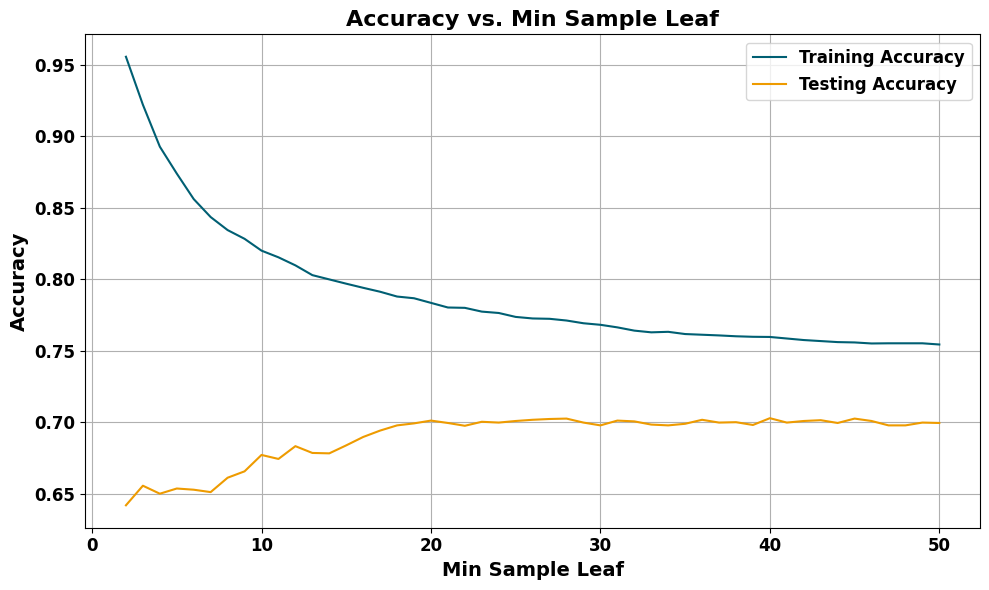

In [35]:
# Define the range of min_samples_leaf values to test.
# This parameter controls the minimum number of samples allowed in each leaf node.
splits = range(2, 51)

# Lists that will store the training and testing accuracies for each candidate value.
train_accuracies = []
test_accuracies = []

# Convert labels to integers for np.bincount, which the tree uses to pick the most common class.
y_train_int = np.asarray(y_train, dtype=int)
y_test_int = np.asarray(y_test, dtype=int)

# Loop through each possible value of min_samples_leaf.
for min_split in splits:

    # Build a tree with the current min_samples_leaf value.
    # We keep min_samples_split fixed at 2 and allow unlimited depth to isolate the effect
    # of the leaf size constraint.
    tree = build_tree(
        X_train_enc_v,
        y_train_int,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=min_split
    )

    # Predict on the full training set to measure how well the model fits the training data.
    train_pred = np.array([predict(tree, xi) for xi in X_train_enc_v])

    # Predict on the test set to measure generalisation performance.
    test_pred = np.array([predict(tree, xi) for xi in X_test_enc_v])

    # Compute training and testing accuracies for this value of min_samples_leaf.
    train_accuracies.append(calculate_accuracy(y_train_int, train_pred))
    test_accuracies.append(calculate_accuracy(y_test_int, test_pred))

# Plot the accuracy curves to visualise the effect of min_samples_leaf.
plt.figure(figsize=(10, 6))

# Training accuracy curve.
plt.plot(splits, train_accuracies, label='Training Accuracy', color="#005F73")

# Testing accuracy curve.
plt.plot(splits, test_accuracies, label='Testing Accuracy', color="#EE9B00")

# Axis labels and title.
plt.xlabel('Min Sample Leaf', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.title('Accuracy vs. Min Sample Leaf', fontsize=16, fontweight='bold')

# Bold tick labels for readability.
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Bold legend text.
legend = plt.legend(fontsize=12)
for text in legend.get_texts():
    text.set_fontweight('bold')

# Add grid and fix layout.
plt.grid(True)
plt.tight_layout()


plt.show()


As our decision tree gains new hyperparameters like min_samples_split and min_samples_leaf, our original k fold function is no longer enough. That first version only supported max_depth, so it could not evaluate the new parameters or pass them correctly into the tree builder. Since we now want to experiment with several configurations and eventually run a grid search, the evaluation routine must evolve as well. The updated k fold accepts all the tree hyperparameters, applies them during training in each fold, and returns both the individual scores and their summary statistics. This ensures that every parameter setting is tested fairly and consistently across folds.

In [36]:
def k_fold_cross_validation(
    X, y, k=5, seed=15, max_depth=None, min_samples_split=2, min_samples_leaf=1, scorer=None
):
    if scorer is None:
        scorer = accuracy_scorer
    X = np.asarray(X)
    y = np.asarray(y)
    n = len(X)
    rng = np.random.default_rng(seed)
    indices = rng.permutation(n)
    folds = np.array_split(indices, k)
    scores = []
    for test_idx in folds:
        test_idx = np.asarray(test_idx)
        # preserve order, no sorting side effect
        train_mask = np.ones(n, dtype=bool)
        train_mask[test_idx] = False
        train_idx = np.where(train_mask)[0]
        model = build_tree(
            X[train_idx], y[train_idx],
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf
        )
        y_pred = np.array([predict(model, xi) for xi in X[test_idx]])
        scores.append(scorer(y[test_idx], y_pred))
    scores = np.asarray(scores, dtype=float)
    return scores, float(scores.mean()), float(scores.std(ddof=1))

# Code listing 3.36: Let the search begin.

We reached the stage where we will start doing some hyper parameter optimisation. Yes, this is when the fun part of machine learning finally begins.

In [37]:
def grid_search(
    X, y,
    max_depth_values, min_samples_split_values, min_samples_leaf_values,
    k=5, random_state=15, scorer=None
):
    # Convert inputs to NumPy arrays for consistent indexing and speed.
    X = np.asarray(X)
    y = np.asarray(y).astype(int)

    # Number of samples
    n = len(X)

    # Create a reproducible random generator and shuffle indices.
    # These shuffled indices will be reused for all parameter combinations.
    rng = np.random.RandomState(random_state)
    indices = rng.permutation(n)

    # Split the shuffled indices into k folds once, so each param set
    # uses *exactly* the same folds. This is essential for fair comparison.
    folds = np.array_split(indices, k)

    # Track the best performing configuration.
    best_mean = -np.inf    # highest mean accuracy wins
    best_std = np.inf      # if means tie, the lowest variance wins
    best_params = None
    best_scores = None

    # Loop over every possible combination of the three hyperparameters.
    for md in max_depth_values:
        for mss in min_samples_split_values:
            for msl in min_samples_leaf_values:

                # Evaluate this specific param combination with k fold.
                scores, mean_score, std_score = k_fold_cross_validation(
                    X, y,
                    k=k,
                    seed=random_state,     # same seed ensures reproducibility
                    max_depth=md,
                    min_samples_split=mss,
                    min_samples_leaf=msl,
                    scorer=scorer
                )

                # Check if this combination is better than the current best.
                # Primary criterion: higher mean score
                # Tie breaker: smaller standard deviation
                if mean_score > best_mean:
                    best_mean = mean_score
                    best_std = std_score
                    best_params = (md, mss, msl)
                    best_scores = scores

    # Return the best mean accuracy, best parameters and the fold scores.
    return best_mean, best_params, best_scores


### The experimentation with 3 parameters for the porpuses of the grid search demonstration

In [38]:
scores, mean_scores, std = k_fold_cross_validation(X_train_enc_v, y_train, 5,  seed=15, 
                                                max_depth=5, min_samples_split=10, min_samples_leaf=10,
                                               scorer = calculate_accuracy)

print("Mean accuracy for cross-validation with hyper parameters:",np.round(mean_scores,3))


Mean accuracy for cross-validation with hyper parameters: 0.722


# Code listing 3.38: Searching.

Following this, we will define our hyper parameter ranges and run a grid search routine that optimises for recall.

In [39]:
# Define the ranges of hyperparameters we want to experiment with.
# These are not meant to be exhaustive, only enough to demonstrate grid search.

depth_range = [None, 1, 3, 5, 6, 20]     # Different maximum depths the tree can grow to
split_range = [10, 20, 50]               # Minimum number of samples required to split a node
leaf_range = [10, 20, 50]                # Minimum number of samples required at a leaf

# Run the grid search over all combinations of the three parameter ranges.
# This will perform k fold cross validation for each combination.
metric, best_params_acc, scores = grid_search(
    X_train_enc_v, y_train,
    max_depth_values=depth_range,
    min_samples_split_values=split_range,
    min_samples_leaf_values=leaf_range,
    k=5,                   # Use 5 fold CV
    random_state=15,       # Ensures reproducible fold assignment
    scorer=calculate_accuracy
)

# Print the best mean accuracy returned by the grid search
# along with the parameters that achieved it.
print("The best accuracy of our grid search:",np.round(metric,3) )
print("Our best parameters returned from the grid search:", best_params_acc)


The best accuracy of our grid search: 0.728
Our best parameters returned from the grid search: (6, 10, 50)


## We now have to test our best parameters to check if the model is overfitting.

First we start with computing the accuracy on the test set 

In [40]:
# Build a decision tree using the best hyperparameters found by the grid search.
# We pass the three optimal values: max_depth, min_samples_split and min_samples_leaf.
tree_acc = build_tree(
    X_train_enc_v,
    y_train,
    max_depth=best_params_acc[0],
    min_samples_split=best_params_acc[1],
    min_samples_leaf=best_params_acc[2]
)

# Generate predictions for the test set using the trained tree.
test_pred_acc = np.array([predict(tree_acc, xi) for xi in X_test_enc_v])

# Compute the accuracy of the model on the unseen test data.
accuracy_test = calculate_accuracy(y_test, test_pred_acc)

# Print the final test accuracy so we can evaluate overfitting.
print("Accuracy computed on our test set:", np.round(accuracy_test,3))


Accuracy computed on our test set: 0.708


### Following we use the same decision tree but to predict using the training set 

In [41]:
train_pred_acc = np.array([predict(tree_acc, xi) for xi in X_train_enc_v])
accuracy_train = calculate_accuracy(y_train, train_pred_acc)
print("Accuracy for computed in our training set:", np.round(accuracy_train,3))


Accuracy for computed in our training set: 0.743


# Code listing 3.39: The code for the confusion.

In [42]:
def confusion_matrix(y_true, y_pred):
    # Determine all unique class labels that appear in either the true labels or predictions.
    # This ensures the matrix includes every class present in the data.
    labels = np.unique(np.concatenate([y_true, y_pred]))

    # Create a mapping from each label to a row or column index.
    # Example: if labels are [0, 1], then label_to_index becomes {0: 0, 1: 1}.
    label_to_index = {label: idx for idx, label in enumerate(labels)}

    # Initialize an empty square matrix of size (num_classes x num_classes).
    # Each cell will count occurrences of true class vs predicted class.
    confusion = np.zeros((len(labels), len(labels)), dtype=int)

    # Loop through each pair of true and predicted labels.
    for true, pred in zip(y_true, y_pred):
        # Convert each label to its corresponding matrix index.
        true_index = label_to_index[true]
        pred_index = label_to_index[pred]

        # Increase the count for this true-predicted combination.
        confusion[true_index, pred_index] += 1

    # Return the completed confusion matrix.
    return confusion


# Code listing 3.40: Hit us with the truth.

In [43]:
cfm_accuracy = confusion_matrix(y_test, test_pred_acc)
# Extract sorted labels to use as row and column names
labels = np.unique(np.concatenate([y_test, test_pred_acc]))

# Create a nice DataFrame
cfm_df = pd.DataFrame(
    cfm_accuracy,
    index=[f"True {l}" for l in labels],
    columns=[f"Pred {l}" for l in labels]
)

cfm_df

,Pred 0,Pred 1
True 0,1201,561
True 1,485,1333


# Code Listing 3.41: Welcome recall... who's the other one?

It was about time we introduced some more performance metrics. Since we care about false negatives, recall becomes an important one for us, so we will work with it from now on. Precision is also a widely used metric, so we include it as well.

In [44]:
def calculate_recall(y_true, y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    actual_positives = np.sum(y_true == 1)
    return true_positives / actual_positives if actual_positives != 0 else 0

def calculate_precision(y_true, y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    predicted_positives = np.sum(y_pred == 1)
    return true_positives / predicted_positives if predicted_positives != 0 else 0


# Code listing 3.42: Higher? It never saw the data...

We now start the same process of hyper parameter grid search optimisation, but this time using a new performance metric: recall.

In [45]:

# Run a grid search, but now using recall as the performance metric.
# We reuse the same hyperparameter ranges as before, only changing the scorer.
metric, best_params_recall, scores = grid_search(
    X_train_enc_v, y_train,
    max_depth_values=depth_range,
    min_samples_split_values=split_range,
    min_samples_leaf_values=leaf_range,
    k=5,                  # Five fold cross validation
    random_state=15,      # Ensure reproducibility
    scorer=calculate_recall   # Optimise for recall instead of accuracy
)

# Display the best recall value achieved during grid search.
print("The best recall of our grid search:", np.round(metric,3))

# Show the hyperparameter combination that produced that best recall.
print("Our best parameters returned from the grid search:", best_params_recall)


The best recall of our grid search: 0.755
Our best parameters returned from the grid search: (6, 10, 50)


We will now repeat the same tests we did for accuracy. This means we check the recall values for the model trained on the training set and evaluated on both the training set and the test set, using the parameters returned from the grid search.

### We will start with the the recall on the test set.

In [46]:
tree_recall = build_tree(X_train_enc_v, y_train, max_depth=best_params_recall[0],
                  min_samples_split=best_params_recall[1], 
                  min_samples_leaf=best_params_recall[2])
test_pred_recall = np.array([predict(tree_recall, xi) for xi in X_test_enc_v])

recall_test = calculate_recall(y_test, test_pred_recall)

print("Recall computed on our test set:", np.round(recall_test,3))


Recall computed on our test set: 0.733


### Now let's check the recall on the training set.

In [47]:
train_pred_recall = np.array([predict(tree_recall, xi) for xi in X_train_enc_v])
recall_train = calculate_recall(y_train, train_pred_recall)

print("Recall computed on our training set:", np.round(recall_train,3))


Recall computed on our training set: 0.771


### Let's check that confusion matrix also.

In [48]:
cfm_accuracy = confusion_matrix(y_test, test_pred_recall)
# Extract sorted labels to use as row and column names
labels = np.unique(np.concatenate([y_test, test_pred_recall]))

# Create a nice DataFrame
cfm_df = pd.DataFrame(
    cfm_accuracy,
    index=[f"True {l}" for l in labels],
    columns=[f"Pred {l}" for l in labels]
)

cfm_df

,Pred 0,Pred 1
True 0,1201,561
True 1,485,1333


# Code lisiting 3.43: Show us how important you really are.

Bellow we will have a cool function to complement our trees and return the feature importance.

In [49]:
def get_feature_importances(tree, X, y):
    # Convert the target array to a flat NumPy array.
    # This helps avoid shape-related issues during recursion.
    y = np.asarray(y).ravel()

    # If X has zero elements (empty array), we cannot compute importances.
    # Return a vector of zeros matching the number of features.
    if X.size == 0:
        return np.zeros(X.shape[1])

    # Total number of samples that reach the root node.
    # We use this later to weight each split by its sample proportion.
    total_samples = y.size

    # If there are no target values, we also return zeros.
    if total_samples == 0:
        return np.zeros(X.shape[1])

    # Initialise the importance scores for each feature.
    # These will accumulate the impurity reductions caused by splits on each feature.
    importances = np.zeros(X.shape[1])

    # Recursive helper function that traverses the tree.
    # It receives the current node and the subset of data reaching that node.
    def recurse(node, local_X, local_y):
        # Every node is stored as a tuple: (feature_index, threshold, left_subtree, right_subtree)
        # If feature_index is None, this node is a leaf and no further splits happen here.
        if node[0] is None:
            return

        # Unpack the node into its components.
        feature, threshold, left_subtree, right_subtree = node

        # For the feature at this split, determine which samples go to the left child
        # and which go to the right child. This must match the logic used in build_tree.
        left_mask = local_X[:, feature] < threshold
        right_mask = local_X[:, feature] >= threshold

        # Extract the feature values and labels that follow each branch.
        left_X, left_y = local_X[left_mask], local_y[left_mask]
        right_X, right_y = local_X[right_mask], local_y[right_mask]

        # Compute how many samples reach this node and how many go left or right.
        n_local = local_y.size
        n_left = left_y.size
        n_right = right_y.size

        # If either side receives no samples, the split is meaningless
        # and does not contribute to feature importance.
        if n_left == 0 or n_right == 0:
            return

        # Compute the Gini impurity at the parent node.
        gini_parent = gini(local_y)

        # Compute the Gini impurity for the left and right branches.
        gini_left = gini(left_y)
        gini_right = gini(right_y)

        # Compute the weighted average impurity after the split.
        weighted_gini = (
            (n_left / n_local) * gini_left +
            (n_right / n_local) * gini_right
        )

        # The gain is the reduction in impurity caused by this feature split.
        gain = gini_parent - weighted_gini

        # Accumulate the gain into the importance score of this feature.
        # We weight it by the proportion of samples reaching this node
        # so deeper nodes with few samples have less influence.
        importances[feature] += gain * (n_local / total_samples)

        # Continue recursively exploring left and right subtrees.
        recurse(left_subtree, left_X, left_y)
        recurse(right_subtree, right_X, right_y)

    # Start recursion from the root node, using the full dataset.
    recurse(tree, X, y)

    # After collecting all gains, normalise so the importances sum to 1.
    # This makes the result easier to interpret.
    s = importances.sum()
    if s > 0:
        importances /= s

    return importances


### Now we need a way to plot our features, because a visual is always a good way to draw some conclusions

In [50]:
def plot_feature_importances(tree, X, y, feature_names=None):
    # Compute feature importances using our custom function.
    # This gives us a numeric score for each feature based on impurity reduction.
    importances = get_feature_importances(tree, X, y)

    # If the user did not supply feature names, generate simple placeholder names.
    # This ensures the plot always has readable labels.
    if feature_names is None:
        feature_names = [f"Feature {i}" for i in range(len(importances))]

    # Sort the importances so the most relevant features appear at the top.
    # argsort gives ascending order, so we reverse it to get descending order.
    indices = np.argsort(importances)[::-1]

    # Apply the sorted order to importances and feature names.
    sorted_importances = importances[indices]
    sorted_feature_names = [feature_names[i] for i in indices]

    # Reverse the arrays because horizontal bar plots display from bottom to top.
    # This ensures the most important feature appears visually at the top.
    sorted_importances = sorted_importances[::-1]
    sorted_feature_names = sorted_feature_names[::-1]

    # Create a figure for the plot.
    plt.figure(figsize=(10, 8))

    # Draw a horizontal bar chart of the importances.
    # Each bar corresponds to a feature.
    plt.barh(
        range(len(importances)),
        sorted_importances,
        align='center',
        color='#005F73'   # Dark blue style for consistency across plots
    )

    # Label each bar with its corresponding feature name.
    # Larger fonts and bold text help with readability.
    plt.yticks(
        range(len(importances)),
        sorted_feature_names,
        fontsize=12,
        fontweight='bold'
    )
    plt.xticks(fontsize=12, fontweight='bold')

    # Add titles and axis labels to give context to the plot.
    plt.xlabel('Importance', fontsize=14, fontweight='bold')
    plt.ylabel('Features', fontsize=14, fontweight='bold')
    plt.title('Feature Importances', fontsize=16, fontweight='bold')

    # Improve the spacing around the plot to prevent label clipping.
    plt.tight_layout()
    # Display the final visual.
    plt.show()


Because we need a generic decision tree to have an unbiased view of how important our features are, we will train one and then plot the feature importance.

In [51]:
generic_tree = build_tree(X_train_enc_v, y_train, max_depth=None)


# Figure 3.24: Anyone out there not helping?

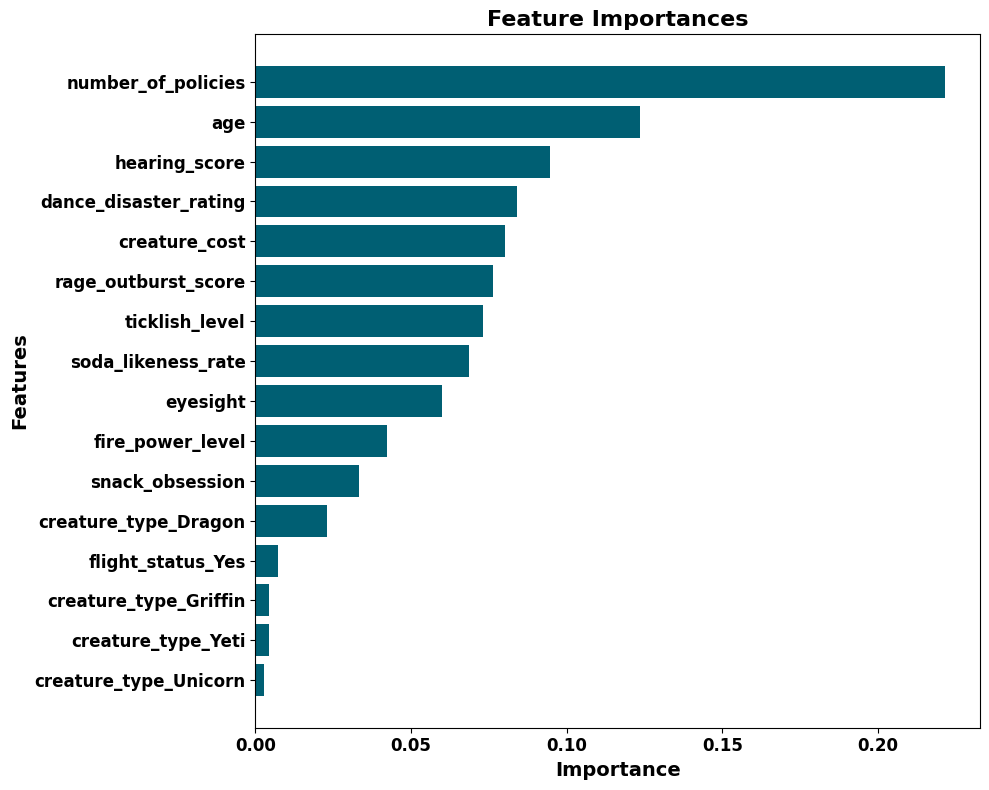

In [52]:
plot_feature_importances(generic_tree, X_train_enc_v, y_train, feature_names=X_train_enc.columns.tolist())

## Hyper paramter tunning of a trees with features that have mora than 2% importance for recall

In [53]:
imp_dict =  get_feature_importances(generic_tree, X_train_enc_v, y_train)

# Code Lisiting 3.44: We will drop some of you.

We will remove some features, specifically the ones whose importance is less than or equal to 2 percent, and then run a grid search with cross validation.

In [54]:
# Compute feature importances using the generic decision tree.
imp_dict = get_feature_importances(generic_tree, X_train_enc_v, y_train)

# Number of features in the encoded training set.
n_features = X_train_enc_v.shape[1]

# Convert importances to a NumPy array for easy masking and indexing.
importances = np.array(imp_dict)

# Select features whose importance is greater than 2 percent.
# This threshold is arbitrary and only used to keep the most relevant features.
mask = importances > 0.02
selected_idx = np.where(mask)[0]

# Slice the training and test sets to keep only the selected features.
X_train_selected = X_train_enc_v[:, selected_idx]
X_test_selected  = X_test_enc_v[:, selected_idx]

# Define the hyperparameter ranges as before.
depth_range = [None, 1, 3, 5, 6, 20]
split_range = [10, 20, 50]
leaf_range = [10, 20, 50]

# Run grid search again, now using only the selected features and optimising for recall.
metric, best_params_recall, scores = grid_search(
    X_train_selected, y_train,
    max_depth_values=depth_range,
    min_samples_split_values=split_range,
    min_samples_leaf_values=leaf_range,
    k=5,
    random_state=15,
    scorer=calculate_recall
)

# Print the best recall and the corresponding hyperparameters.
# Display the best recall value achieved during grid search.
print("The best recall of our grid search:", np.round(metric,3))

# Show the hyperparameter combination that produced that best recall.
print("Our best parameters returned from the grid search:", best_params_recall)


The best recall of our grid search: 0.755
Our best parameters returned from the grid search: (6, 10, 50)


### Testing the model optimised with the best parameters in the test set reduce features

In [55]:
tree = build_tree(X_train_selected, y_train, max_depth=best_params_recall[0],
                  min_samples_split=best_params_recall[1], 
                  min_samples_leaf=best_params_recall[2])
test_pred_recall = np.array([predict(tree, xi) for xi in X_test_selected])

recall = calculate_recall(y_test, test_pred_recall)

print("Recall computed on our test set:", np.round(recall,3))


Recall computed on our test set: 0.733


### Test overfit with model optimised for recall reduce features

In [56]:
train_pred_recall = np.array([predict(tree, xi) for xi in X_train_selected])
recall = calculate_recall(y_train, train_pred_recall)

print("Recall computed on our training set:", np.round(recall,3))


Recall computed on our training set: 0.771


### One more confusion matrix

In [57]:
cfm_recall = confusion_matrix(y_test, test_pred_recall)
# Extract sorted labels to use as row and column names
labels = np.unique(np.concatenate([y_test, test_pred_recall]))

# Create a nice DataFrame
cfm_df = pd.DataFrame(
    cfm_recall,
    index=[f"True {l}" for l in labels],
    columns=[f"Pred {l}" for l in labels]
)

cfm_df

,Pred 0,Pred 1
True 0,1201,561
True 1,485,1333


# Code listing 3.45 - A simple example makes everyone happy.

At this stage we enter the realm of random forests. So first we understand the concept of bootstrapping.

In [58]:
# List of numbers from which we will draw bootstrap samples.
numbers = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# We will create three bootstrap samples, each of size 10.
bootstrap_samples = []

for _ in range(3):
    # A bootstrap sample is created by sampling with replacement.
    # For each sample, we draw 10 values from 'numbers'.
    sample = [random.choice(numbers) for _ in range(10)]
    bootstrap_samples.append(sample)

# Display the generated bootstrap samples.
for i, sample in enumerate(bootstrap_samples, 1):
    print(f"Bootstrap Sample {i}: {sample}")


Bootstrap Sample 1: [40, 10, 90, 10, 30, 40, 10, 10, 30, 60]
Bootstrap Sample 2: [40, 20, 60, 80, 60, 50, 70, 50, 60, 40]
Bootstrap Sample 3: [40, 60, 60, 40, 50, 90, 70, 40, 100, 80]


# Code listing 4.2: A class full of class.

Yes, classes. Since most of the time we will work with libraries and import their methods, I felt it is useful for us to understand what a class is and how it works. Classes are useful for many things. Bellow we introduce a small use case to make this concept a little less abstract.

In [59]:
class Report:
    def __init__(self, creature, fire_used, gnome_casualties, can_fly, reported_by):
        # Name of the creature involved in the incident.
        self.creature = creature

        # Amount of fire used, for cases where the creature produces flames.
        self.fire_used = fire_used

        # Number of gnomes injured or affected. This may contain messy strings.
        self.gnome_casualties = gnome_casualties

        # Boolean or flag indicating whether the creature can fly.
        self.can_fly = can_fly

        # Name or ID of the witness or system that reported the incident.
        self.reported_by = reported_by

    def clean_gnomes(self):
        """
        Standardises the gnome_casualties field so that it always becomes an integer.
        This method resolves inconsistent formats such as text descriptions or numeric strings.
        """

        # Only attempt to clean if the value is a string.
        if isinstance(self.gnome_casualties, str):

            # Convert common vague descriptions to a default integer value.
            # These words imply a large but unspecified number of casualties.
            if self.gnome_casualties.lower() in {"too many", "a lot", "lots"}:
                self.gnome_casualties = 5

            # If the string contains digits only, convert it directly to an integer.
            elif self.gnome_casualties.isdigit():
                self.gnome_casualties = int(self.gnome_casualties)

            # For any other text (invalid or unknown), default to 0 casualties.
            else:
                self.gnome_casualties = 0


# Code listing 4.3: Id's?!

We start by showing how we can create independent instances of a class

In [60]:
# Create two reports
r1 = Report(creature="Dragon", fire_used=True, gnome_casualties=3, can_fly=True, reported_by="Bob the Elf")
r2 = Report(creature="Yeti", fire_used=False, gnome_casualties="a lot", can_fly=False, reported_by="Sophie from Claims")
print(id(r1))
print(id(r2))

5089875088
5091018576


# Code listing 4.4: What do you have for us r1?

In [61]:
print("Creature", r1.creature)

Creature Dragon


# Code listing 4.6: Clean those gnomes.

Now we will see the utility of the methods.

In [62]:
print("Gnome casualties:", r2.gnome_casualties)
r2.clean_gnomes()
print("Gnome casualties:", r2.gnome_casualties)

Gnome casualties: a lot
Gnome casualties: 5


# Code listing 4.13: The best of the forests.

In [63]:
# Create a default RandomForestClassifier.
# We will not set any hyperparameters here because the search will tune them.
rf = RandomForestClassifier()

# Define the hyperparameter ranges that the randomized search will explore.
# Each key corresponds to a parameter in RandomForestClassifier.
param_distributions = {
    "n_estimators": np.arange(10, 201),     # Number of trees from 10 to 200
    "max_depth": np.arange(1, 51),          # Tree depth from shallow (1) to deep (50)
    "min_samples_split": np.arange(1, 76),  # Minimum samples required to split a node
    "min_samples_leaf": np.arange(1, 76),   # Minimum samples allowed in a leaf
    "random_state": [15],                   # Keep the model reproducible
}

# Define the scoring metric for optimisation.
# Here we optimise specifically for recall.
scorer = make_scorer(recall_score)

# Set up the randomized search object.
# RandomizedSearchCV samples random combinations of hyperparameters instead 
# of testing every possible combination (like GridSearchCV).
search = RandomizedSearchCV(
    estimator=rf,                         # Base model to tune
    param_distributions=param_distributions,
    n_iter=5,                             # Number of random combinations to try
    scoring=scorer,                       # Use recall as the evaluation metric
    cv=5,                                 # 5 fold cross validation
    random_state=42                       # Reproducibility for the search process
)

# Fit the randomized search on the training data.
# This trains many random forests behind the scenes, each with different parameters.
search.fit(X_train_enc_v, y_train)

# Display the highest recall score achieved during the search.
print("The best recall score for the random forest after the random search:", np.round(search.best_score_,3))

# Display the hyperparameter combination that achieved this best score.
print("Best parameters found during the search:")
for k, v in sorted(search.best_params_.items()):
    print(f"  {k}: {v}")
# Extract the best parameters for later use.
param = search.best_params_


The best recall score for the random forest after the random search: 0.764
Best parameters found during the search:
  max_depth: 13
  min_samples_leaf: 30
  min_samples_split: 38
  n_estimators: 110
  random_state: 15


# Testing the model optimised with the best parameters and the test set 

In [64]:
# Build a new RandomForestClassifier using the best parameters found
# during the randomized search. We plug each hyperparameter into the model.
rf = RandomForestClassifier(
    n_estimators=param["n_estimators"],        # Number of trees in the forest
    max_depth=param["max_depth"],              # Maximum depth of each tree
    min_samples_split=param["min_samples_split"],  # Minimum samples needed to split a node
    min_samples_leaf=param["min_samples_leaf"],    # Minimum samples allowed in a leaf node
    random_state=param["random_state"]         # Seed for reproducibility
)

# Train the random forest using the selected hyperparameters.
rf.fit(X_train_enc_v, y_train)

# Predict the labels for the test set to evaluate generalisation performance.
predictions_test_rf_recall = rf.predict(X_test_enc_v)

# Predict on the training set to check for possible overfitting.
predictions_train_rf_recall = rf.predict(X_train_enc_v)


## Testing RF  optimised with the best parameters for recall and test set 

In [65]:
recall = calculate_recall(y_test, predictions_test_rf_recall)
print("The recall we get on our test set after trainin a random forest with the best set of parameters", np.round(recall,3))

The recall we get on our test set after trainin a random forest with the best set of parameters 0.743


# Testing RF  optimised with the best parameters for recall and train set for overfit 

In [66]:
recall = calculate_recall(y_train, predictions_train_rf_recall)
print("The same configuarion as above but, this time we compute the recall on the training set, you know to check for overfitting signs", np.round(recall,3))

The same configuarion as above but, this time we compute the recall on the training set, you know to check for overfitting signs 0.79


In [67]:
cfm_recall = confusion_matrix(y_test, predictions_test_rf_recall)
cfm_recall

array([[1267,  495],
       [ 468, 1350]])

# Code listing 4.14: Forest, forest what is important to you?

In [68]:
rf = RandomForestClassifier(
    n_estimators=10,
    random_state=15
)
rf.fit(X_train_enc_v, y_train)



RandomForestClassifier(n_estimators=10, random_state=15)

# Code listing 4.15: You know what will be great? Some bars.

In [69]:
def plot_rf_feature_importances(rf, aux_data, filename):
    # Extract the feature names from the auxiliary dataframe.
    # This ensures our plot labels match the encoded dataset columns.
    feature_names = list(aux_data)

    # Raw feature importance values learned by the random forest.
    importances = np.array(rf.feature_importances_)

    # Sort indices from smallest to largest importance so the plot displays
    # low importance at the bottom and high importance at the top.
    idx = np.argsort(importances)

    # Reorder both the importances and their corresponding feature names.
    sorted_importances = importances[idx]
    sorted_feature_names = [feature_names[i] for i in idx]

    # Set up the horizontal bar plot.
    plt.figure(figsize=(12, 8))
    plt.barh(
        range(len(sorted_importances)),
        sorted_importances,
        color='#005F73'
    )

    # Assign the sorted feature names to the y axis.
    plt.yticks(
        range(len(sorted_importances)),
        sorted_feature_names,
        fontsize=12,
        fontweight='bold'
    )
    plt.xticks(fontsize=12, fontweight='bold')

    # Axis labels and plot title.
    plt.xlabel('Importance', fontsize=14, fontweight='bold')
    plt.ylabel('Features', fontsize=14, fontweight='bold')
    plt.title('Feature Importances', fontsize=16, fontweight='bold')

    # Ensure everything fits nicely.
    plt.tight_layout()


    # Show the plot.
    plt.show()


# Figure 4.2: Now we can understand who's working and who's slacking.

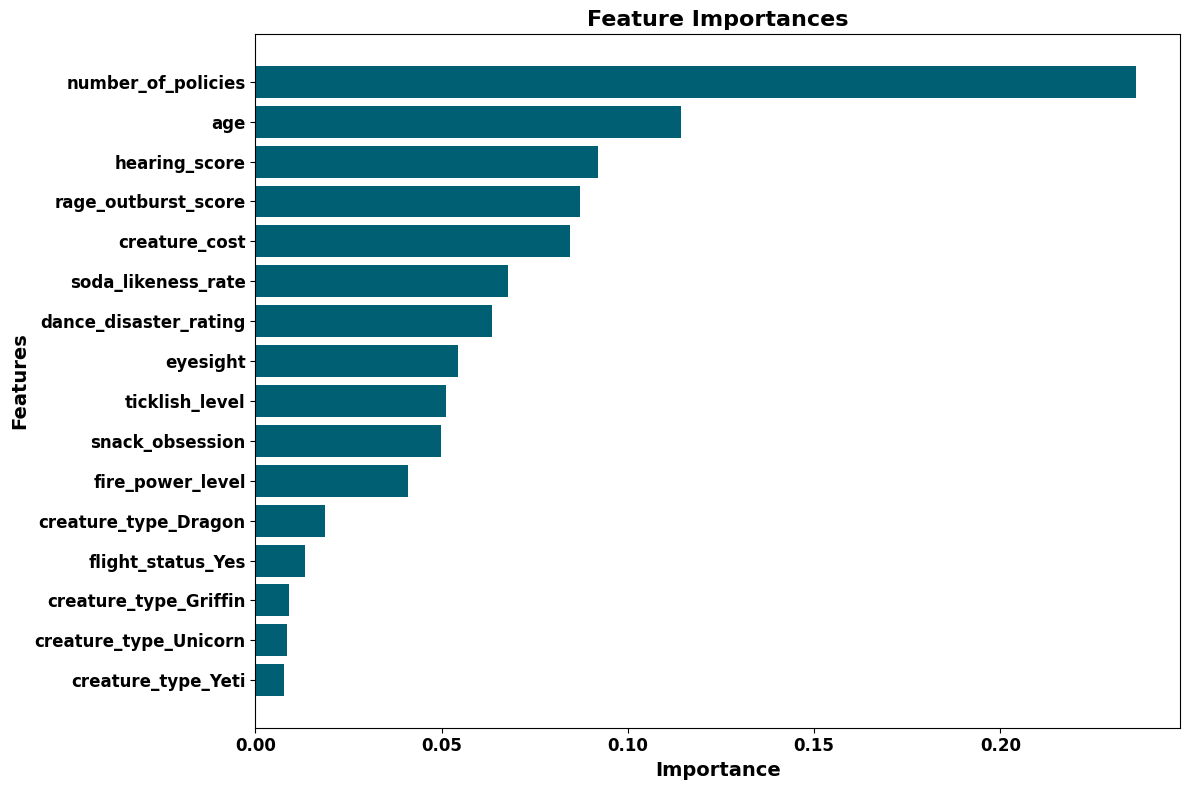

In [70]:
plot_rf_feature_importances(rf, X_train_enc, 'feature_importance_rf.png') 

# Remove features in RF and performan random search

In [71]:
# Extract the feature importances learned by the earlier random forest.
# These values follow the same column order as the encoded feature matrix.
importances = rf.feature_importances_

# Build a mask that keeps only the features whose importance is above 2.5 percent.
# This gives us a smaller set of features that contribute in a meaningful way.
mask = importances > 0.025
selected_idx = np.where(mask)[0]

# Slice the encoded training and testing matrices to keep only the selected columns.
# This reduces dimensionality and may improve generalisation.
X_train_selected = X_train_enc_v[:, selected_idx]
X_test_selected = X_test_enc_v[:, selected_idx]

# Define a base random forest that will be tuned using a random search.
rf_base = RandomForestClassifier()

# Define the hyper parameter search space.
# Each distribution guides how values will be sampled during the search.
param_distributions = {
    "n_estimators": np.arange(10, 201),
    "max_depth": np.arange(1, 51),
    "min_samples_split": np.arange(1, 76),
    "min_samples_leaf": np.arange(1, 76),
    "random_state": [15]
}

# Set up a random search with five sampled combinations.
# We use recall as the scoring metric and a five fold cross validation.
search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=5,
    cv=5,
    scoring="recall",
    random_state=15
)

# Fit the search on the reduced training features.
search.fit(X_train_selected, y_train)

print("CV best score:", search.best_score_)
print("Best parameters found during the search:")
for k, v in sorted(search.best_params_.items()):
    print(f"  {k}: {v}")

# Create a new random forest using the best parameters and fit it on the selected features.
rf_best = RandomForestClassifier(**search.best_params_)
rf_best.fit(X_train_selected, y_train)

# Predict on the reduced test set and compute the final recall.
y_pred = rf_best.predict(X_test_selected)
final_recall_test = recall_score(y_test, y_pred)

# Predict on the reduced training set to check for overfitting.
y_pred_train = rf_best.predict(X_train_selected)
final_recall_train = calculate_recall(y_train, y_pred_train)

# Print the results.
print("Train recall:", np.round(final_recall_train,3))
print("Test recall:", np.round(final_recall_test,3))


CV best score: 0.7500033426831573
Best parameters found during the search:
  max_depth: 29
  min_samples_leaf: 6
  min_samples_split: 3
  n_estimators: 139
  random_state: 15
Train recall: 0.869
Test recall: 0.738


# Figure 4.3: How do they all show up the same number of times?

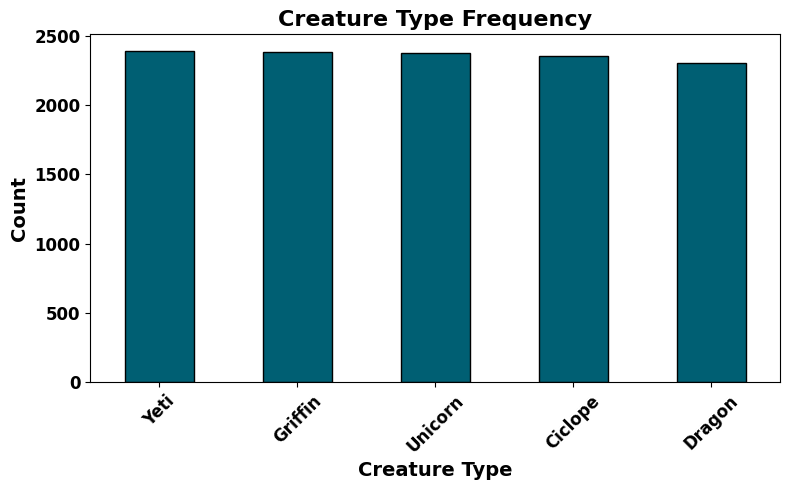

In [72]:
# Count how many times each creature type appears in the dataset.
# This gives us a simple frequency distribution across categories.
creature_counts = data['creature_type'].value_counts()

# Start a new figure for the bar chart and set its size.
plt.figure(figsize=(8, 5))

# Plot a bar chart where each bar represents one creature type and its frequency.
creature_counts.plot(kind='bar', color="#005F73", edgecolor='black')

# Add descriptive title and axis labels with bold formatting.
plt.title('Creature Type Frequency', fontsize=16, fontweight='bold')
plt.xlabel('Creature Type', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')

# Rotate x labels for readability and make all ticks bold.
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adjust spacing so labels and titles fit nicely.
plt.tight_layout()


# Display the plot on screen.
plt.show()


# Figure 4.4: Do you all fly?

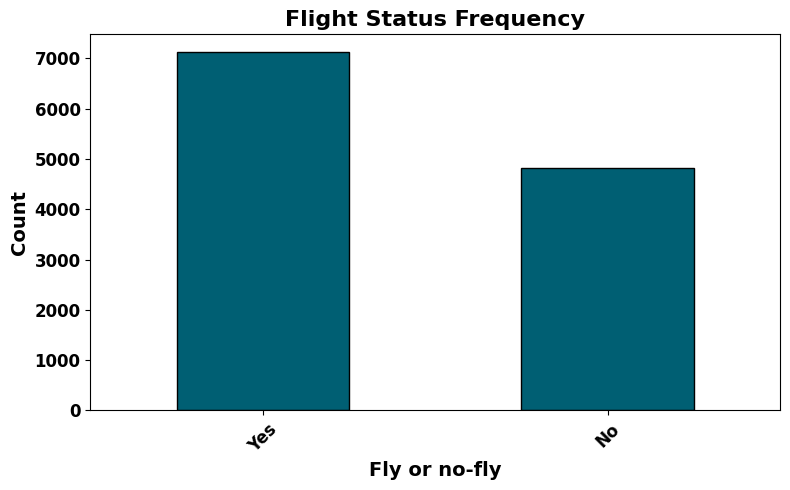

In [73]:
# Count how many records fall into each flight status category.
# This shows how many creatures can fly versus how many cannot.
creature_counts = data['flight_status'].value_counts()

# Create a new figure for the bar chart and set its size.
plt.figure(figsize=(8, 5))

# Plot the flight status counts as a bar chart.
# Each bar represents one category such as can_fly or cannot_fly.
creature_counts.plot(kind='bar', color="#005F73", edgecolor='black')

# Add a clear title and axis labels with bold formatting.
plt.title('Flight Status Frequency', fontsize=16, fontweight='bold')
plt.xlabel('Fly or no-fly', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')

# Rotate x axis labels for readability and make tick labels bold.
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adjust spacing so labels and ticks fit well on the figure.
plt.tight_layout()


# Display the plot.
plt.show()


# Figure 4.5: Who are the brats?

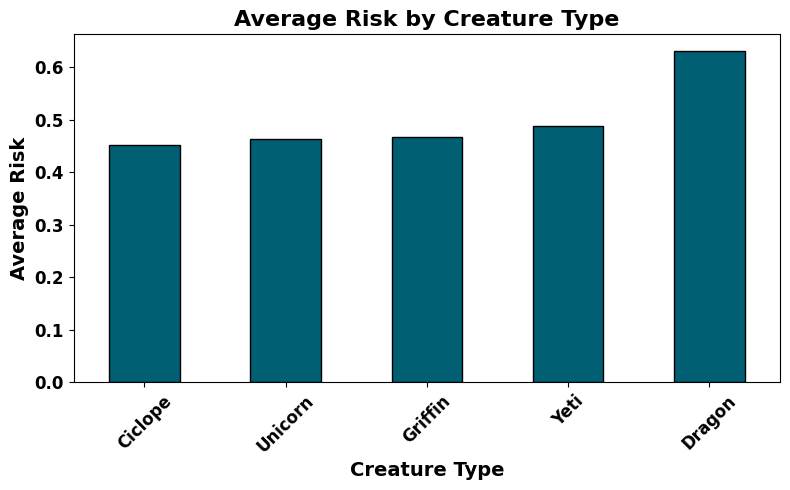

In [74]:
# Compute the average risk value for each creature type.
# This groups the dataset by creature_type and takes the mean of the risk column.
creature_risk_avg = data.groupby("creature_type")["risk"].mean()

# Start a new figure for the bar plot and set the size.
plt.figure(figsize=(8, 5))

# Plot the average risk per creature type.
# Sorted values make the bar chart easier to read from lowest to highest.
creature_risk_avg.sort_values().plot(kind='bar', color="#005F73", edgecolor='black')

# Add a descriptive title and axis labels with bold formatting.
plt.title('Average Risk by Creature Type', fontsize=16, fontweight='bold')
plt.xlabel('Creature Type', fontsize=14, fontweight='bold')
plt.ylabel('Average Risk', fontsize=14, fontweight='bold')

# Rotate x axis labels for readability and format all ticks in bold.
plt.xticks(rotation=45, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Adjust layout so labels and titles fit cleanly.
plt.tight_layout()


# Display the plot.
plt.show()


# Code listing 4.16: You know what will be great? Some bars.

In [75]:

ct_train = X_train_enc_un["creature_type"].astype(str)
ct_test = X_test_enc_un["creature_type"].astype(str)
# Overall mean of the target in the training set
# This value is used as a fallback for unseen categories
global_mean = float(pd.Series(y_train).mean())

# Convert y_train to numpy array for consistent indexing
y_train_arr = y_train.values if isinstance(y_train, pd.Series) else np.array(y_train)

# Use KFold for out-of-fold target encoding on training data to avoid leakage
kf = KFold(n_splits=5, shuffle=True, random_state=42)
te_train = np.full(len(ct_train), global_mean)  # Initialize with global mean

for train_idx, val_idx in kf.split(ct_train):
    ct_tr = ct_train.iloc[train_idx]
    y_tr = y_train_arr[train_idx]
    te_map_fold = (
        pd.DataFrame({"ct": ct_tr.values, "y": y_tr})
          .groupby("ct")["y"].mean()
    )
    te_train[val_idx] = ct_train.iloc[val_idx].map(te_map_fold).fillna(global_mean)

# For the test set, use the mean computed on the full training data
te_map = (
    pd.DataFrame({"ct": ct_train.values, "y": y_train_arr})
      .groupby("ct")["y"].mean()
)
te_test = ct_test.map(te_map).fillna(global_mean)

# Build base frames by dropping the original creature_type column
# Then add a new numeric column with the target encoding
X_train_base = X_train_enc_un.drop(columns=["creature_type"]).copy()
X_test_base = X_test_enc_un.drop(columns=["creature_type"]).copy()
X_train_base["ct_te"] = te_train.astype(float)
X_test_base["ct_te"] = te_test.values.astype(float)
# One hot encode flight_status only, leaving creature_type handled by target encoding
X_train_base = pd.get_dummies(
    X_train_base,
    columns=["flight_status"],
    drop_first=True,
    dtype=float
)
X_test_base = pd.get_dummies(
    X_test_base,
    columns=["flight_status"],
    drop_first=True,
    dtype=float
)
# Make sure the test frame has the same columns and order as the training frame
# Any missing columns in the test set are filled with zeros
X_test_base = X_test_base.reindex(columns=X_train_base.columns, fill_value=0.0)
# Convert the final frames to NumPy arrays, ready for the tree model
X_train_final_ct = X_train_base.values
X_test_final_ct = X_test_base.values
# Ensure targets are plain arrays whether they came from pandas or not
y_train_final = y_train.values if isinstance(y_train, pd.Series) else y_train
y_test_final = y_test.values if isinstance(y_test, pd.Series) else y_test

#  Random forest with CT 

In [76]:
# Define the hyper parameter search space.
# Each range controls how values will be sampled during the random search.
param_distributions = {
    "n_estimators": np.arange(10, 201),
    "max_depth": np.arange(1, 51),
    "min_samples_split": np.arange(1, 76),
    "min_samples_leaf": np.arange(1, 76),
    "random_state": [15]
}

# Create a base random forest. This model will be tuned during the search.
rf_base = RandomForestClassifier()

# Set up a random search that samples five parameter combinations.
# Recall is our scoring metric and we use a five fold cross validation.
search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=5,
    cv=5,
    scoring="recall",
    random_state=15
)

# Fit the search on the final training features.
search.fit(X_train_final_ct, y_train_final)

print("CV best score:", search.best_score_)
print("Best parameters found during the search:")
for k, v in sorted(search.best_params_.items()):
    print(f"  {k}: {v}")

# Build a new random forest using the best parameters from the search
# and fit it on the final training data.
rf_best = RandomForestClassifier(**search.best_params_)
rf_best.fit(X_train_final_ct, y_train_final)

# Predict on the final test set and compute recall.
y_pred = rf_best.predict(X_test_final_ct)
final_recall_test = recall_score(y_test_final, y_pred)

print("Final test recall. This tells us how many actual positives we correctly caught:", np.round(final_recall_test,3))

# Predict on the training set to inspect recall and possible overfitting.
y_pred_train = rf_best.predict(X_train_final_ct)
final_recall_train = calculate_recall(y_train_final, y_pred_train)

print("Final train recall. This tells us how well the model performs on the data it learned from:", np.round(final_recall_train,3))



CV best score: 0.7579548592439723
Best parameters found during the search:
  max_depth: 21
  min_samples_leaf: 20
  min_samples_split: 31
  n_estimators: 181
  random_state: 15
Final test recall. This tells us how many actual positives we correctly caught: 0.744
Final train recall. This tells us how well the model performs on the data it learned from: 0.811


# Code listing 5.1: GBT will you classify something for us?

We now optimise our final model from the first big chapter of the book, the tree based models. Since the target encoding did not get us anywhere with the random forest, we make the executive decision not to use it.

In [77]:
# Create a base gradient boosting classifier.
# We will tune this model with a random search.
gb_base = GradientBoostingClassifier(random_state=15)

# Define the hyper parameter search space.
# These ranges guide how values will be sampled during the search.
param_distributions = {
    "n_estimators": np.arange(10, 201),
    "max_depth": np.arange(1, 11),
    "min_samples_split": np.arange(2, 76),
    "min_samples_leaf": np.arange(1, 76),
    "learning_rate": np.linspace(0.001, 0.3, 300),
    "random_state": [15]
}

# Use recall as the scoring metric since this is our priority.
scorer = make_scorer(recall_score)

# Set up a random search with five sampled parameter combinations
# and a five fold cross validation.
search = RandomizedSearchCV(
    estimator=gb_base,
    param_distributions=param_distributions,
    n_iter=5,
    cv=5,
    scoring=scorer,
    random_state=15
)

# Fit the search on the encoded training set.
search.fit(X_train_enc_v, y_train)

# Print results with meaning.
print("CV best score. This is the best average recall across the five folds:", np.round(search.best_score_,3))
print("Best parameters found during the search:")
for k, v in sorted(search.best_params_.items()):
    print(f"  {k}: {v}")

CV best score. This is the best average recall across the five folds: 0.758
Best parameters found during the search:
  learning_rate: 0.07300000000000001
  max_depth: 5
  min_samples_leaf: 62
  min_samples_split: 74
  n_estimators: 24
  random_state: 15


### Test the resutls of our random search

In [78]:
# Extract the best parameters from the search.
best_params = search.best_params_

# Refit a new gradient boosting model using the best parameters.
gb_best = GradientBoostingClassifier(**best_params)
gb_best.fit(X_train_enc_v, y_train_final)

# Compute recall on the test set.
y_pred_test = gb_best.predict(X_test_enc_v)
test_recall = recall_score(y_test_final, y_pred_test)
print("Final test recall. This tells us how many real positives we correctly identified:",  np.round(test_recall,3))

# Compute recall on the training set to check for possible overfitting.
y_pred_train = gb_best.predict(X_train_enc_v)
train_recall = recall_score(y_train_final, y_pred_train)
print("Final train recall. This shows how well the model performs on the data it learned from:",  np.round(train_recall,3))


Final test recall. This tells us how many real positives we correctly identified: 0.733
Final train recall. This shows how well the model performs on the data it learned from: 0.766


# Figure 5.2: Wait, why are we talking about cats?

/opt/homebrew/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


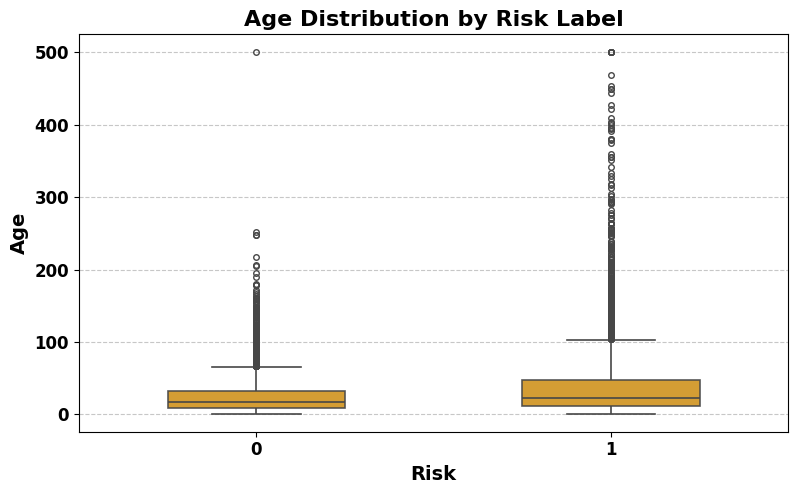

In [79]:

# Create a new figure for the box plot.
plt.figure(figsize=(8, 5))

# Draw a box plot that compares the age distribution across the two risk labels.
sns.boxplot(
    x="risk",
    y="age",
    data=data,
    color="#EE9B00",
    width=0.5,
    fliersize=4,
    linewidth=1.2,
    boxprops=dict(alpha=0.9)
)

# Add title and axis labels.
plt.title("Age Distribution by Risk Label", fontsize=16, fontweight='bold')
plt.xlabel("Risk", fontsize=14, fontweight='bold')
plt.ylabel("Age", fontsize=14, fontweight='bold')

# Add a light horizontal grid for readability.
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout so labels and title fit neatly.
plt.tight_layout()

# Set tick label sizes.
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Save the box plot image.

# Display the plot.
plt.show()


# Figure 5.3: One more whiskey... whisker!

/opt/homebrew/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


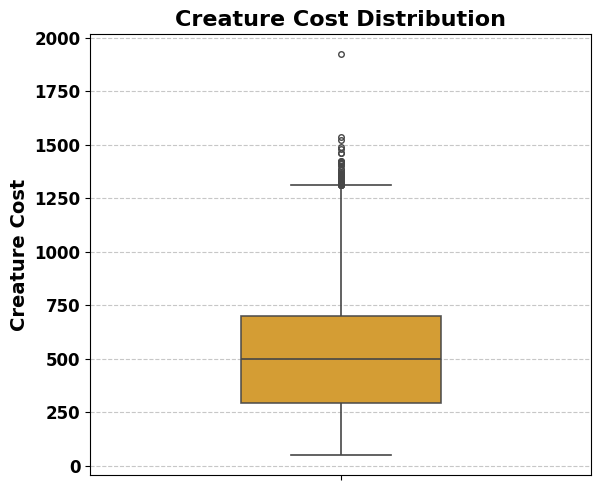

In [80]:
# Create a figure for the box plot.
plt.figure(figsize=(6, 5))

# Draw a box plot for the creature cost distribution.
sns.boxplot(
    y="creature_cost",
    data=data,
    color="#EE9B00",
    width=0.4,
    fliersize=4,
    linewidth=1.2,
    boxprops=dict(alpha=0.9)
)

# Add a title and axis label.
plt.title("Creature Cost Distribution", fontsize=16, fontweight='bold')
plt.ylabel("Creature Cost", fontsize=14, fontweight='bold')

# Add a light grid to help with readability.
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout so everything fits nicely.
plt.tight_layout()

# Format tick labels.
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

# Save the figure to disk.

# Display the plot.
plt.show()


# Table 5.8: Decile thresholds for the creature_cost feature

In [81]:
# Compute decile thresholds for creature_cost.
# We create 11 quantile points from 0 to 1 to define the ten decile boundaries.
deciles = np.quantile(data['creature_cost'], q=np.linspace(0, 1, 11))

# Create a table that shows each decile boundary.
# Rounded to one decimal for easier reading.
decile_table = pd.DataFrame({
    "Decile": [f"{int(p*100)} percent" for p in np.linspace(0, 1, 11)],
    "Threshold": deciles.round(1)
})

decile_table

,Decile,Threshold
0,0 percent,50.0
1,10 percent,109.0
2,20 percent,242.0
3,30 percent,341.0
4,40 percent,420.0
5,50 percent,497.0
6,60 percent,574.0
7,70 percent,655.0
8,80 percent,747.8
9,90 percent,881.0


# Code listing 5.2: New features, new hope.

OK, we now have a new model, a creature cost feature alteration and new features to create.

We begin by creating a copy of the dataset so we keep the original untouched and tidy while we engineer new features. From here we assign each creature a cost decile and build the extra features we need, like the burp burn index, the owl ratio, and the grandma boogie index. Once the features are ready, we build the matrix for the model by dropping creature cost, the customer id, and the risk label since these do not belong in the training set. We then split the data, impute missing numerical and categorical values, and one hot encode the creature type and flight status. After we align the columns between train and test, we convert everything to numpy arrays so the models can work with them, the usual jazz.

In [82]:
# Make a clean working copy so we keep the original dataset untouched.
data_copy = data.copy()
# New engineered features (these are pointwise, no leakage).
data_copy['burp_burn_index'] = (
    data_copy['fire_power_level'] * data_copy['soda_likeness_rate']
)
data_copy['owl_ratio'] = (
    data_copy['eyesight'] / (data_copy['hearing_score'] + 1e-6)
)
alpha = 0.03
data_copy['grandma_boogie_index'] = (
    data_copy['ticklish_level']
    + data_copy['dance_disaster_rating'] * np.exp(alpha * data_copy['age'])
)
# Build feature matrix and target.
X_ctq = data_copy.drop(['risk', 'customer_id', 'creature_cost'], axis=1)
y_ctq = data_copy['risk']
# Train test split directly into DataFrames and Series.
X_train_ctq, X_test_ctq, y_train_ctq, y_test_ctq = train_test_split(
    X_ctq, y_ctq, test_size=0.3, random_state=42
)
# Add decile ranking using only training data to avoid leakage.
# Compute quantiles on train's creature_cost.
train_cost = data_copy.loc[X_train_ctq.index, 'creature_cost']  # Align with train indices
deciles = np.quantile(train_cost, q=np.linspace(0, 1, 11))
# Assign deciles to train.
X_train_ctq['cost_decile'] = pd.cut(train_cost, bins=deciles, labels=False, include_lowest=True)
X_train_ctq['cost_decile'] = (X_train_ctq['cost_decile'] + 1) / 10.0
# Assign deciles to test using train's bins.
test_cost = data_copy.loc[X_test_ctq.index, 'creature_cost']  # Align with test indices
X_test_ctq['cost_decile'] = pd.cut(test_cost, bins=deciles, labels=False, include_lowest=True)
X_test_ctq['cost_decile'] = (X_test_ctq['cost_decile'] + 1) / 10.0
# Handle any values outside train range (though unlikely if same distribution).
X_train_ctq['cost_decile'] = X_train_ctq['cost_decile'].fillna(0.5)  # Fallback to median decile
X_test_ctq['cost_decile'] = X_test_ctq['cost_decile'].fillna(0.5)
# Compute min and max policies from train only, excluding NaNs.
min_pol = X_train_ctq["number_of_policies"].dropna().min()
max_pol = X_train_ctq["number_of_policies"].dropna().max()
# Impute number_of_policies with random integers inside the observed range from train.
X_train_ctq["number_of_policies"] = X_train_ctq["number_of_policies"].apply(
    lambda x: np.random.randint(min_pol, max_pol + 1) if pd.isna(x) else int(x)
)
X_test_ctq["number_of_policies"] = X_test_ctq["number_of_policies"].apply(
    lambda x: np.random.randint(min_pol, max_pol + 1) if pd.isna(x) else int(x)
)
# Categorical imputation using train's observed types.
train_types = X_train_ctq["creature_type"].dropna().unique()
X_train_ctq["creature_type"] = X_train_ctq["creature_type"].apply(
    lambda x: np.random.choice(train_types) if pd.isna(x) else x
)
X_test_ctq["creature_type"] = X_test_ctq["creature_type"].apply(
    lambda x: np.random.choice(train_types) if pd.isna(x) else x
)
# One hot encode creature_type and flight_status.
X_train_ctq = pd.get_dummies(
    X_train_ctq,
    columns=['creature_type', 'flight_status'],
    drop_first=True,
    dtype=int
)
X_test_ctq = pd.get_dummies(
    X_test_ctq,
    columns=['creature_type', 'flight_status'],
    drop_first=True,
    dtype=int
)
# Align columns.
X_test_ctq = X_test_ctq.reindex(columns=X_train_ctq.columns, fill_value=0)
# Final numpy arrays for the model.
X_train_ctq_v = X_train_ctq.values
X_test_ctq_v = X_test_ctq.values

# Figure 5.4: Some of our new ones are important!

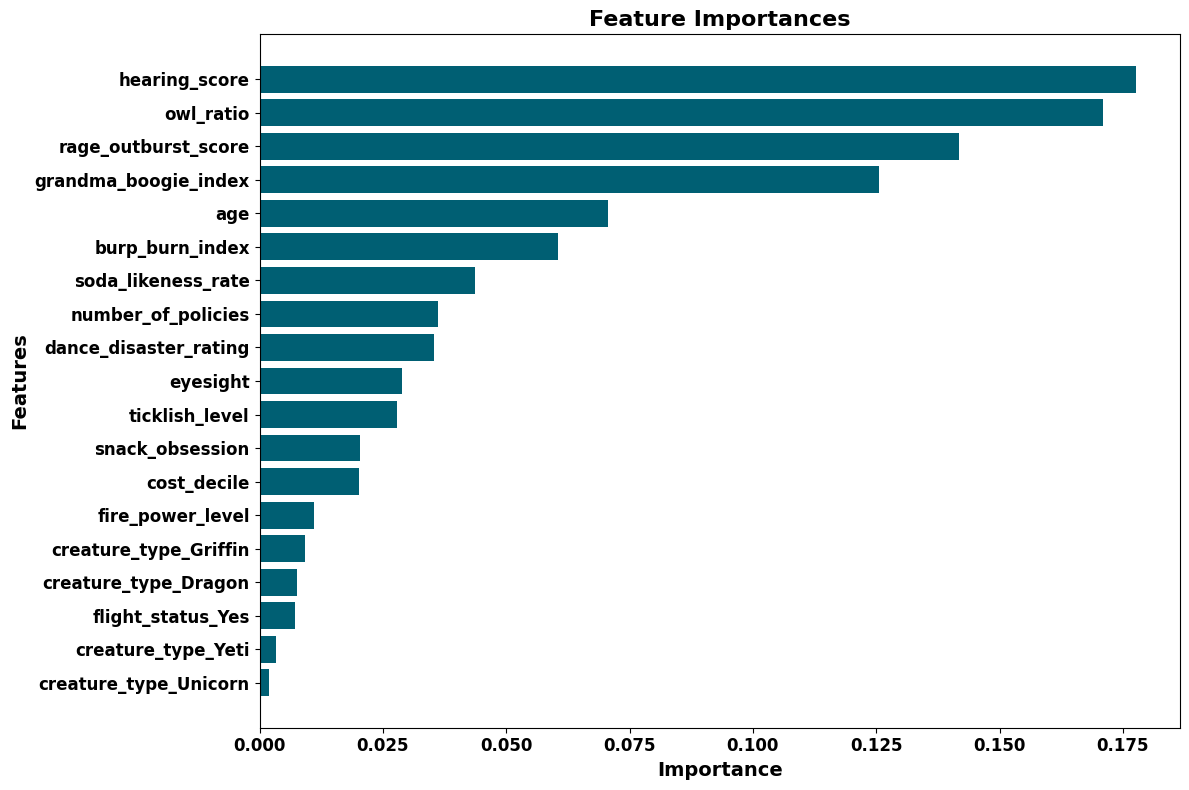

In [83]:
gbt = GradientBoostingClassifier(random_state=15)
gbt.fit(X_train_ctq, y_train)
plot_rf_feature_importances(gbt, X_train_ctq, 'gbt_importance.png')


### Time to try our GBT with all the new features baby!

In [84]:
# Define the hyper parameter search space.
# These ranges guide how values will be sampled during the random search.
param_distributions = {
    "n_estimators": np.arange(10, 201),
    "max_depth": np.arange(1, 11),
    "min_samples_split": np.arange(2, 76),
    "min_samples_leaf": np.arange(1, 76),
    "learning_rate": np.linspace(0.001, 0.3, 300),
    "random_state": [15]
}

# Use recall as the scoring metric since this is our priority in this chapter.
scorer = make_scorer(recall_score)

# Set up a random search that samples five parameter combinations.
# A five fold cross validation estimates performance for each combination.
search = RandomizedSearchCV(
    estimator=gbt,
    param_distributions=param_distributions,
    n_iter=5,
    cv=5,
    scoring=scorer,
    random_state=15
)

# Fit the search on the training data with engineered features.
search.fit(X_train_ctq_v, y_train_ctq)

# Format and print the cross validation performance.
print("Cross validation best recall. This is the highest average recall across the five folds:")
print(f"  {search.best_score_:.4f}")

# Format and print the best hyper parameter set.
print("\nBest hyper parameters found during the search:")
for key, value in search.best_params_.items():
    print(f"  {key}: {value}")

# Store the best parameter dictionary for later use.
best_params = search.best_params_


Cross validation best recall. This is the highest average recall across the five folds:
  0.7541

Best hyper parameters found during the search:
  random_state: 15
  n_estimators: 114
  min_samples_split: 72
  min_samples_leaf: 51
  max_depth: 10
  learning_rate: 0.045


### Now let's check if this sister is overfitting.

In [85]:
# Build a new gradient boosting model using the best parameters from the search.
gb_best = GradientBoostingClassifier(**best_params)

# Fit the model on the full training set.
gb_best.fit(X_train_ctq_v, y_train_ctq)

# Compute recall on the test set.
y_pred_test = gb_best.predict(X_test_ctq_v)
test_recall = recall_score(y_test_ctq, y_pred_test)
print("Final test recall. This tells us how many real positives we correctly identified:")
print(f"  {test_recall:.4f}")

# Compute recall on the training set to inspect possible overfitting.
y_pred_train = gb_best.predict(X_train_ctq_v)
train_recall = recall_score(y_train_ctq, y_pred_train)
print("\nFinal train recall. This shows how well the model performs on the data it learned from:")
print(f"  {train_recall:.4f}")


Final test recall. This tells us how many real positives we correctly identified:
  0.7422

Final train recall. This shows how well the model performs on the data it learned from:
  0.8641


We now reach the final routine of the book and once again we need a new feature set. This time we want to use the original creature cost feature. The good news is that we do not need to redo all the work. We keep all our engineered features as they are, since they carry the story the model needs to learn. The only change is that we drop the cost decile and keep the raw creature cost. Everything else stays the same. We use the same split, the same imputations, and the same one hot encoding.

In [86]:
# Start from the dataset that already includes all engineered features.
df_base = data_copy.copy()

# Target.
y = df_base["risk"]

# Feature matrix with raw creature_cost.
# We keep all engineered features and drop only the label, the ID, the decile.
X_cost = df_base.drop(
    ["risk", "customer_id"],
    axis=1
)

# Train test split.
X_train_cost, X_test_cost, y_train, y_test = train_test_split(
    X_cost, y, test_size=0.3, random_state=42
)

# Impute number_of_policies.
X_train_cost["number_of_policies"] = X_train_cost["number_of_policies"].apply(
    lambda x: np.random.randint(min_pol, max_pol + 1) if pd.isna(x) else int(x)
)
X_test_cost["number_of_policies"] = X_test_cost["number_of_policies"].apply(
    lambda x: np.random.randint(min_pol, max_pol + 1) if pd.isna(x) else int(x)
)

# Categorical imputation.
train_types = X_train_cost["creature_type"].dropna().unique()
X_train_cost["creature_type"] = X_train_cost["creature_type"].apply(
    lambda x: np.random.choice(train_types) if pd.isna(x) else x
)
X_test_cost["creature_type"] = X_test_cost["creature_type"].apply(
    lambda x: np.random.choice(train_types) if pd.isna(x) else x
)

# One hot encode creature_type and flight_status.
X_train_cost = pd.get_dummies(
    X_train_cost,
    columns=["creature_type", "flight_status"],
    drop_first=True,
    dtype=int
)
X_test_cost = pd.get_dummies(
    X_test_cost,
    columns=["creature_type", "flight_status"],
    drop_first=True,
    dtype=int
)

# Align columns.
X_test_cost = X_test_cost.reindex(columns=X_train_cost.columns, fill_value=0)

# Convert to numpy arrays for modelling.
X_train_cost_v = X_train_cost.values
X_test_cost_v = X_test_cost.values


# Table 5.10: Yellow for the real winner.

Having created our feature set, it is time to optimise all the models for all the metrics. What a day, I know.

To do this, we build a routine where, for each model, we run a random search tuned to the metric we care about, fit the best version, and measure its train and test performance. We also compute a simple business cost from the confusion matrix so we see how each model behaves in practical terms.

In [87]:
def cost_from_confusion(y_true, y_pred, cost_fn=10000, cost_fp=500):
    """
    Compute a simple business cost from a confusion matrix.

    cost_fn is the cost of a false negative.
    cost_fp is the cost of a false positive.

    We ignore true positives and true negatives in the cost.
    """
    # Unpack the confusion matrix into the four basic counts.
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Compute total cost using the provided cost per error type.
    total_cost = cost_fn * fn + cost_fp * fp
    return total_cost


def build_model_table_metricwise(
    X_train, y_train, X_test, y_test,
    random_state=15,
    n_iter=5,
    cv=5
):
    """
    For each model and each metric we:

      1. Run a random search hyper parameter tuning focused on that metric.
      2. Fit the best model on the full training set.
      3. Compute train and test performance for that same metric.
      4. Compute the business cost on the test set.
      5. Store everything in a tidy table.

    The result is a DataFrame where each row corresponds to
    one model and one metric.
    """

    # Base models to compare.
    # DT  decision tree
    # RF  random forest
    # GBT gradient boosted trees.
    models = {
        "DT": DecisionTreeClassifier(random_state=random_state),
        "RF": RandomForestClassifier(random_state=random_state),
        "GBT": GradientBoostingClassifier(random_state=random_state),
    }

    # Hyper parameter spaces for each model.
    # These ranges are in the same spirit as your custom tuning earlier in the book.
    param_spaces = {
        "DT": {
            "max_depth": np.arange(1, 11),
            "min_samples_split": np.arange(2, 76),
            "min_samples_leaf": np.arange(1, 76),
            "random_state": [random_state],
        },
        "RF": {
            "n_estimators": np.arange(10, 201),
            "max_depth": np.arange(1, 11),
            "min_samples_split": np.arange(2, 76),
            "min_samples_leaf": np.arange(1, 76),
            "random_state": [random_state],
        },
        "GBT": {
            "n_estimators": np.arange(10, 201),
            "max_depth": np.arange(1, 11),
            "min_samples_split": np.arange(2, 76),
            "min_samples_leaf": np.arange(1, 76),
            "learning_rate": np.linspace(0.001, 0.3, 300),
            "random_state": [random_state],
        },
    }

    # For each metric we store:
    #  human friendly metric name,
    #  sklearn scorer name to pass to RandomizedSearchCV,
    #  function to compute the metric on train and test predictions.
    metrics_info = [
        ("Accuracy", "accuracy", accuracy_score),
        ("Precision", "precision", precision_score),
        ("Recall", "recall", recall_score),
        ("F1-score", "f1", f1_score),
    ]

    # We will collect one row per model and metric.
    rows = []

    # Outer loop over model type  decision tree, random forest, gradient boosting.
    for model_name, base_model in models.items():
        # Inner loop over metrics  accuracy, precision, recall, F1.
        for nice_name, scoring_name, metric_func in metrics_info:

            # Set up a random search tuned to this specific metric.
            # For example, when scoring_name is "recall",
            # RandomizedSearchCV will pick hyper parameters that maximise recall.
            search = RandomizedSearchCV(
                estimator=base_model,
                param_distributions=param_spaces[model_name],
                n_iter=n_iter,
                cv=cv,
                scoring=scoring_name,
                random_state=random_state,
                n_jobs=-1,   # use all cores available
            )

            # Run the random search on the training data.
            search.fit(X_train, y_train)

            # Best model refitted on the full training set for this metric.
            best_model = search.best_estimator_

            # Best mean cross validation score for this metric.
            rs_score = search.best_score_

            # Predictions on train and test for this tuned model.
            y_train_pred = best_model.predict(X_train)
            y_test_pred = best_model.predict(X_test)

            # Compute the metric on train and test.
            train_score = metric_func(y_train, y_train_pred)
            test_score = metric_func(y_test, y_test_pred)

            # Simple overfit indicator  difference between train and test.
            delta = train_score - test_score

            # Compute business cost on the test predictions.
            # Here we assume false negatives are very expensive
            # compared to false positives.
            total_cost = cost_from_confusion(
                y_test, y_test_pred,
                cost_fn=10000,
                cost_fp=500
            )

            # Normalise the cost to a cost per 1000 customers
            # so numbers are easier to compare across experiments.
            cost_per_1000 = total_cost / 1000.0

            # Add a row to the results list.
            rows.append(
                {
                    "Model": model_name,      # DT, RF, or GBT
                    "Metric": nice_name,      # Accuracy, Precision, Recall, F1-score
                    "RS Score": rs_score,     # best mean cross validation score
                    "Test Score": test_score, # metric on held out test set
                    "Train Score": train_score,  # metric on training set
                    "δ": delta,               # train minus test
                    "Cost / 1000": cost_per_1000,  # business cost normalised
                }
            )

    # Convert the list of dictionaries into a DataFrame
    # so we get a tidy summary table.
    df_results = pd.DataFrame(rows)
    return df_results


## Let's see this table.

In [88]:
table_df = build_model_table_metricwise(
    X_train_cost_v, y_train,
    X_test_cost_v, y_test,
    random_state=15,
    n_iter=5,
    cv=5
)

table_df

,Model,Metric,RS Score,Test Score,Train Score,δ,Cost / 1000
0,DT,Accuracy,0.724019,0.720391,0.748563,0.028172,4899.0
1,DT,Precision,0.716870,0.708874,0.746409,0.037535,4899.0
2,DT,Recall,0.744818,0.738861,0.756022,0.017161,4899.0
3,DT,F1-score,0.730442,0.723557,0.751185,0.027628,4899.0
4,RF,Accuracy,0.738985,0.735475,0.756106,0.020631,4340.0
5,RF,Precision,0.728905,0.721526,0.759134,0.037608,4745.5
6,RF,Recall,0.766753,0.770446,0.782733,0.012288,4340.0
7,RF,F1-score,0.746748,0.742593,0.763167,0.020574,4340.0
8,GBT,Accuracy,0.738745,0.743296,0.858597,0.115301,4592.0
9,GBT,Precision,0.733837,0.734358,0.852034,0.117676,4592.0


# Table 6.1 Lucky us the results are similar.

The narrative now shifts to something very real world. We realise we forgot to check the balance of our labels. Once we catch it, we go back and rebalance the dataset, and of course this means we have to run the full optimisation routine again. 

To rebalance the set, we take the original test split and reshape it so that positives make up roughly twenty percent of the data instead of whatever skewed rate we started with. We keep all positives, sample the right number of negatives to hit the target rate, and shuffle everything back together. This gives us a test set that matches the imbalance we expect in production. 


In [89]:
# === Distribution shift: 80/20 test set ===
# Helper function to reshape the test set into an eighty twenty distribution.
def build_imbalanced_test(X, y, target_pos_rate=0.2, random_state=42):
    X = X.reset_index(drop=True)
    y = pd.Series(y).reset_index(drop=True)
    pos_idx = y[y == 1].index
    neg_idx = y[y == 0].index
    n_pos = len(pos_idx)
    if n_pos == 0:
        raise ValueError("No positive cases")
    desired_neg = int(n_pos * (1 - target_pos_rate) / target_pos_rate)
    n_neg = min(desired_neg, len(neg_idx))
    rng = np.random.default_rng(random_state)
    sampled_neg_idx = rng.choice(neg_idx, size=n_neg, replace=False)
    new_idx = np.concatenate([pos_idx.values, sampled_neg_idx])
    rng.shuffle(new_idx)
    return X.iloc[new_idx].reset_index(drop=True), y.iloc[new_idx].reset_index(drop=True)

# Use the X_test_cost DataFrame created in the feature engineering block.
X_test_8020, y_test_8020 = build_imbalanced_test(X_test_cost, y_test, target_pos_rate=0.2) 

# Final numpy arrays for modeling
# X_train_cost (DataFrame) is the correct input for training features.
X_train_enc_v_80 = X_train_cost.values.astype(np.float32) 
X_test_enc_v_80 = X_test_8020.values.astype(np.float32)
y_train_v = y_train.values
y_test_v = y_test_8020.values


# Table 6.1 Lucky us the results are similar.

In [90]:
table_df = build_model_table_metricwise(
    X_train_enc_v_80, y_train_v,    
    X_test_enc_v_80, y_test_v,          random_state=15,
    n_iter=5,
    cv=5
)

In [91]:
table_df

,Model,Metric,RS Score,Test Score,Train Score,δ,Cost / 1000
0,DT,Accuracy,0.724019,0.720391,0.748563,0.028172,4899.0
1,DT,Precision,0.716870,0.708874,0.746409,0.037535,4899.0
2,DT,Recall,0.744818,0.738861,0.756022,0.017161,4899.0
3,DT,F1-score,0.730442,0.723557,0.751185,0.027628,4899.0
4,RF,Accuracy,0.738985,0.735475,0.756106,0.020631,4340.0
5,RF,Precision,0.728905,0.721526,0.759134,0.037608,4745.5
6,RF,Recall,0.766753,0.770446,0.782733,0.012288,4340.0
7,RF,F1-score,0.746748,0.742593,0.763167,0.020574,4340.0
8,GBT,Accuracy,0.738745,0.743296,0.858597,0.115301,4592.0
9,GBT,Precision,0.733837,0.734358,0.852034,0.117676,4592.0


In [92]:
# Define the hyper parameter search space for the random forest.
param_distributions = {
    "n_estimators": np.arange(10, 201),
    "max_depth": np.arange(1, 11),
    "min_samples_split": np.arange(2, 76),
    "min_samples_leaf": np.arange(1, 76),
    "random_state": [15],
}

# Base random forest model to be tuned.
rf_base = RandomForestClassifier(random_state=15)

# We use F1 as the metric for this search.
scorer = make_scorer(f1_score)

# Set up a random search with five sampled parameter combinations
# and a five fold cross validation.
search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=5,
    cv=5,
    scoring=scorer,
    random_state=15,
)

# Run the random search on the training data using X_train_enc_v_80 and y_train_v
search.fit(X_train_enc_v_80, y_train_v) 

# Report the cross validation performance and the best parameters.
print("Cross validation best F1 score:")
print(f"  {search.best_score_:.4f}")
print("\nBest hyper parameters found during the search:")
for key, value in search.best_params_.items():
    print(f"  {key}: {value}")

# Extract the best parameters and rebuild the random forest with them.
best_params = search.best_params_
rf_best = RandomForestClassifier(**best_params)

# Fit the tuned random forest on the full training set
rf_best.fit(X_train_enc_v_80, y_train_v)

# Evaluate on the imbalanced test set
y_pred_test = rf_best.predict(X_test_enc_v_80)

test_recall = recall_score(y_test_v, y_pred_test)
test_precision = precision_score(y_test_v, y_pred_test)
test_f1 = f1_score(y_test_v, y_pred_test)

print("\nTest set performance on the eighty twenty distribution:")
print(f"  Recall    that is the share of real positives we caught:   {test_recall:.4f}")
print(f"  Precision that is the share of predicted positives correct: {test_precision:.4f}")
print(f"  F1 score:            {test_f1:.4f}")

Cross validation best F1 score:
  0.7467

Best hyper parameters found during the search:
  random_state: 15
  n_estimators: 174
  min_samples_split: 32
  min_samples_leaf: 58
  max_depth: 9

Test set performance on the eighty twenty distribution:
  Recall    that is the share of real positives we caught:   0.7704
  Precision that is the share of predicted positives correct: 0.7167
  F1 score:            0.7426


# Listing 6.6: Let that n go!

In [93]:
np.random.seed(15)

# Parameters
true_recall = test_recall          # estimated recall from the model
fixed_precision = test_precision   # precision assumed fixed
alpha = 0.05                       # 95 percent CI
target_width = 0.03                # desired CI width
n_simulations = 1000              # Monte Carlo draws

# Storage lists for plotting
n_values = []
widths = []

min_n = None

# Loop over candidate sample sizes of actual positives
for n in range(10, 2000):     # 2000 is safe, not restrictive
    recalls = np.random.binomial(n, true_recall, n_simulations) / n
    f1_scores = 2 * fixed_precision * recalls / (fixed_precision + recalls)

    lower = np.percentile(f1_scores, alpha * 100 / 2)
    upper = np.percentile(f1_scores, 100 * (1 - alpha / 2))
    width = upper - lower

    n_values.append(n)
    widths.append(width)

    if min_n is None and width <= target_width:
        min_n = n
        print(f"Required actual positives (n): {n}")
        print(f"95 percent CI: ({lower:.3f}, {upper:.3f}) width: {width:.3f}")


Required actual positives (n): 601
95 percent CI: (0.728, 0.757) width: 0.029


# Figure 6.6: Do we trust anything here?

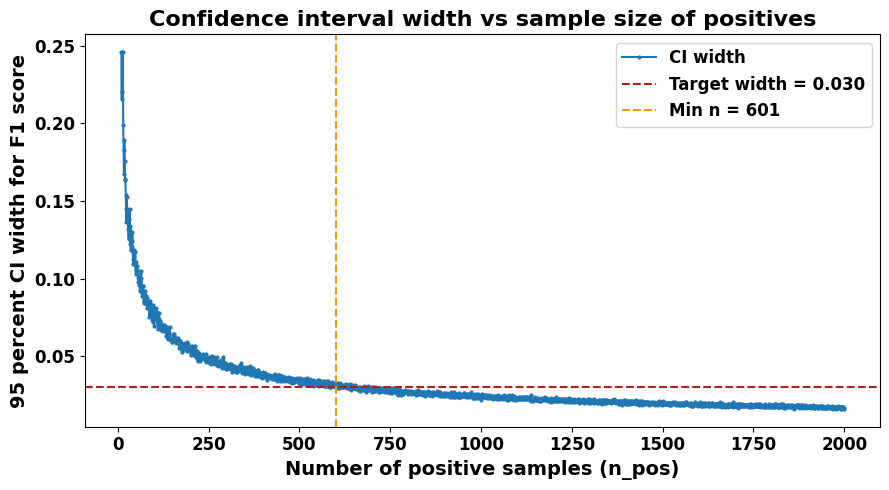

In [94]:
plt.figure(figsize=(9, 5))

plt.plot(n_values, widths, marker="o", markersize=2, label="CI width")
plt.axhline(target_width, linestyle="--", color="#AE2012", label=f"Target width = {target_width:.3f}")

if min_n is not None:
    plt.axvline(min_n, linestyle="--", color="#EE9B00", label=f"Min n = {min_n}")

plt.title("Confidence interval width vs sample size of positives", fontsize=16, fontweight="bold")
plt.xlabel("Number of positive samples (n_pos)", fontsize=14, fontweight="bold")
plt.ylabel("95 percent CI width for F1 score", fontsize=14, fontweight="bold")

plt.xticks(fontsize=12, fontweight="bold")
plt.yticks(fontsize=12, fontweight="bold")

legend = plt.legend(fontsize=12)
for t in legend.get_texts():
    t.set_fontweight("bold")

plt.tight_layout()
plt.show()

# Code listing 6.7: Shap! Or is it SHAP? / Figure 6.8: Nice colours, but what do they really mean?

 99%|===================| 7113/7160 [01:16<00:00]       /var/folders/3l/w0lcfxyd1dbf4xgmxwbz2w6r0000gn/T/ipykernel_15377/1500539892.py:31: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


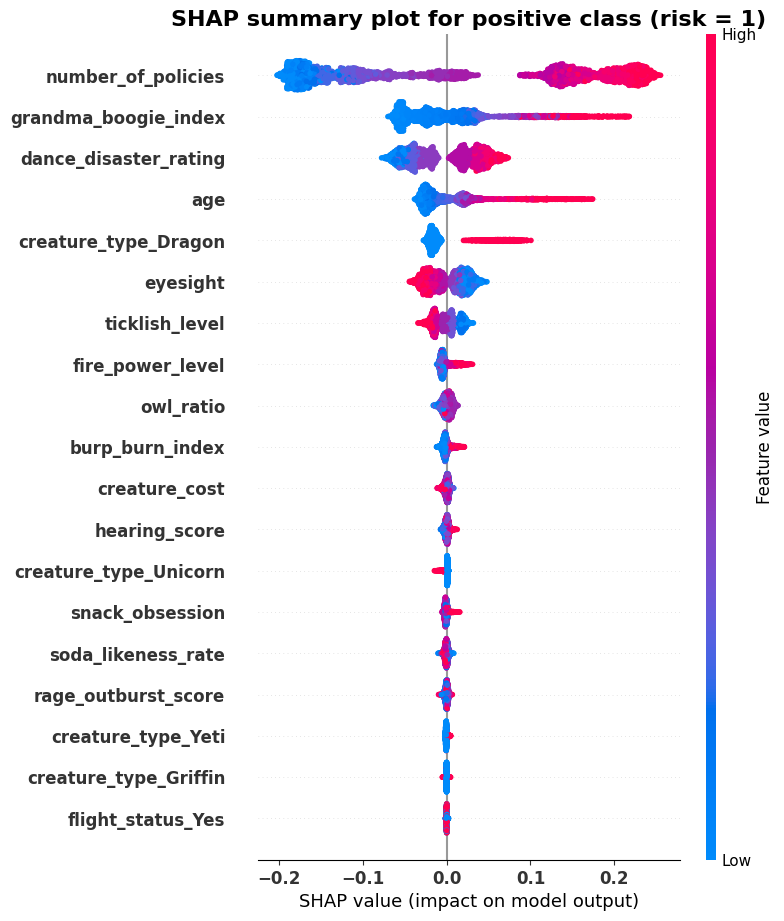

In [95]:
# Rebuild DataFrames so SHAP sees feature names.
# NOTE: Variables are now consistent with previous steps.
X_train_rf = pd.DataFrame(X_train_enc_v_80, columns=X_train_cost.columns)
X_test_rf = pd.DataFrame(X_test_enc_v_80, columns=X_train_cost.columns)

# 1. Feature names from the DataFrame.
feature_names = X_train_rf.columns.tolist()

# 2. SHAP explainer for the tuned random forest.
explainer = shap.TreeExplainer(rf_best, X_train_rf)

# 3. SHAP values on the test set.
shap_values = explainer.shap_values(X_test_rf)

# 4. For binary classification, shap_values can be either
#    a list of arrays (one per class) or a single array.
# --- FIX FOR VALUEERROR APPLIED HERE ---
if isinstance(shap_values, list):
    sv = shap_values[1]    # Case 1: List of 2D arrays (class 1)
else:
    # Case 2: Single 3D array (N_samples, N_features, N_classes).
    # We select the positive class (index 1) from the last axis.
    sv = shap_values[:, :, 1]
# ----------------------------------------

# --- Diagnostic Code (Now fixed to run) ---
mean_abs_shap = np.abs(sv).mean(axis=0) # Now calculates mean on a 2D array, resulting in 1D array
feature_importance = pd.Series(mean_abs_shap, index=feature_names)

# 5. SHAP summary plot for the positive class.
shap.summary_plot(
    sv,
    X_test_rf,
    feature_names=feature_names,
    show=False
)

# Add a bold title.
plt.title("SHAP summary plot for positive class (risk = 1)", fontsize=16, fontweight="bold")

# Bold axis tick labels.
ax = plt.gca()
for lbl in ax.get_yticklabels():
    lbl.set_fontweight("bold")
    lbl.set_fontsize(12)

for lbl in ax.get_xticklabels():
    lbl.set_fontweight("bold")
    lbl.set_fontsize(12)

plt.show()

# Figure 6.9: Some of the new ones are important.

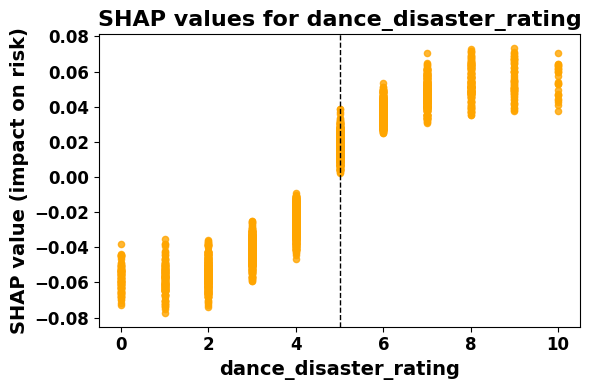

In [96]:
# SHAP returns either:
#    a list of arrays (one per class), or
#    a single array (model already compressed classes internally).
if isinstance(shap_values, list):
    sv = shap_values[1]    # Case 1: List of 2D arrays (class 1)
else:
    # Case 2: Single 3D array (N_samples, N_features, N_classes).
    # We select the positive class (index 1) from the last axis.
    sv = shap_values[:, :, 1]
# ------------------------

# We pick the feature we want to analyse.
feature = "dance_disaster_rating"

# Get the column index of this feature in the encoded dataset.
idx = feature_names.index(feature)

# Extract the actual feature values from the test set.
# These will be the x axis of the scatter plot.
x_vals = X_test_enc_v_80[:, idx]

# Extract the SHAP values associated with this same feature.
# These will be the y axis of the scatter plot.
y_vals = sv[:, idx]

# Set up the figure.
plt.figure(figsize=(6, 4))

# Create a scatter plot of feature value vs SHAP impact.
plt.scatter(
    x_vals,
    y_vals,
    color="orange",
    s=20,
    alpha=0.8
)

# Add a vertical reference line at the median feature value.
threshold = np.median(x_vals)
plt.axvline(threshold, color="black", linestyle="--", linewidth=1)

# Labels and title.
plt.xlabel(feature, fontsize=14, fontweight='bold')
plt.ylabel("SHAP value (impact on risk)", fontsize=14, fontweight='bold')
plt.title(f"SHAP values for {feature}", fontsize=16, fontweight='bold')

# Tick formatting.
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

plt.tight_layout()

plt.show()

# Figure 6.10: How important are those dragon owners?

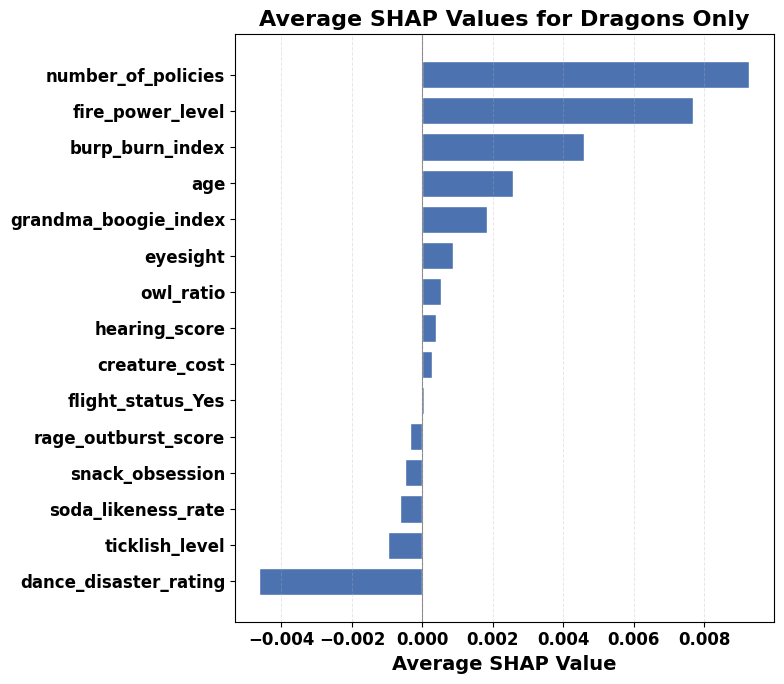

In [97]:
# Style
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 13,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 12,
    'figure.figsize': (8, 7)
})

# 1. Select SHAP values for the positive class (risky class)
# --- FIX APPLIED HERE: Ensure sv is 2D ---
if isinstance(shap_values, list):
    sv = shap_values[1] # Case 1: List of 2D arrays (class 1)
else:
    # Case 2: Single 3D array. Select the positive class (index 1) from the last axis.
    sv = shap_values[:, :, 1] 
# ----------------------------------------

# 2. Convert test to DataFrame
X_test_df = pd.DataFrame(X_test_enc_v_80, columns=feature_names)

# 3. Filter real dragons
dragon_mask = X_test_df["creature_type_Dragon"] == 1
sv_dragons = sv[dragon_mask.values, :] # sv is now guaranteed to be 2D, so sv_dragons is also 2D

# 4. Remove all creature types
creature_cols = [c for c in feature_names if c.startswith("creature_type_")]
keep_cols = [c for c in feature_names if c not in creature_cols]
keep_idx = [feature_names.index(c) for c in keep_cols]

sv_dragons_clean = sv_dragons[:, keep_idx]
feature_names_clean = keep_cols

# 5. Signed average SHAP values
# This now results in a 1D array (N_clean_features,) as expected
avg_shap = np.mean(sv_dragons_clean, axis=0) 

# 6. Sort
df_plot = pd.DataFrame({
    "feature": feature_names_clean,
    "avg_shap": avg_shap
}).sort_values("avg_shap", ascending=True)

# 7. Plot 
plt.figure(figsize=(8, 7))
plt.barh(
    df_plot["feature"],
    df_plot["avg_shap"],
    color="#4c72b0",
    edgecolor="white",
    height=0.75
)

plt.xlabel("Average SHAP Value", fontsize=14, fontweight='bold')
plt.title("Average SHAP Values for Dragons Only", fontsize=16, fontweight='bold')

plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')

plt.axvline(0, color="black", linewidth=0.8, alpha=0.4)
plt.grid(axis="x", alpha=0.3, linestyle="--", linewidth=0.7)

plt.tight_layout()
plt.show()

# Table 6.4: The fire_power_level of the dragons in log-odds

In [98]:
# pick correct SHAP values for positive class
if isinstance(shap_values, list):
    sv = shap_values[1]
else:
    sv = shap_values[:, :, 1]

# feature index
f_idx = feature_names.index("fire_power_level")

# filter for dragon owners only
dragon_mask = X_test_enc_v_80[:, feature_names.index("creature_type_Dragon")] == 1
sv_fire = sv[dragon_mask, f_idx]

# quantiles to compute
qs = [90, 80, 70, 60, 50, 40, 30, 20, 10]

# build dataframe
df_quantiles = pd.DataFrame({
    "quantile": qs,
    "shap_value": [np.percentile(sv_fire, q) for q in qs]
})

# optional rounding
df_quantiles["shap_value"] = df_quantiles["shap_value"].round(3)

df_quantiles

,quantile,shap_value
0,90,0.021
1,80,0.017
2,70,0.014
3,60,0.010
4,50,0.008
5,40,0.003
6,30,-0.001
7,20,-0.002
8,10,-0.004


# API SECTION

### Save our models and ETL configurations

We now step away from notebooks and start working with scripts. At least for this chapter. We will return to notebooks later. For now, we need something more rigid and more reusable than an interactive environment.

Because we are about to build an API that receives raw data and returns classifications for our three selected models, we need to persist more than just fitted estimators. We must also persist the assumptions and transformations that turn raw inputs into something a model can actually use. The API itself should only handle requests and responses. It should not perform any heavy data processing. That responsibility belongs entirely to the models we load into it.

This is where this routine comes in.

The routine starts from a raw dataframe and ends with trained models saved to disk, ready to load into an API. At this point, we stop experimenting and start producing artifacts meant for reuse. These models will later receive raw inputs at inference time and must produce predictions without any manual preprocessing.

We begin by separating the target variable from the feature set and performing a train test split. We deliberately keep the data raw at this stage. We do not fix missing values, encode categories, or adjust types yet. We want the model itself to own every transformation it applies to the data.

Next, we extract all schema defining information from the training data only. We collect the creature types observed during training and build the complete set of columns produced by one hot encoding. These elements define the feature space that every future input must follow, whether it comes from a batch process or a live API request.

We then wrap the original ETL logic into a callable transformation so the model can execute it both during training and later in real time inside the API. When a request reaches the Flask endpoint, the model receives raw, unprocessed data and immediately applies the same transformations used during training. During this transformation, we impute missing numerical values using a controlled random process, sample missing categorical values from categories seen during training, one hot encode categorical variables, and align the result to the fixed training schema. This process always produces a numeric matrix with a stable shape that the classifier can consume directly. By embedding this logic inside a FunctionTransformer, preprocessing becomes part of the model itself rather than external code that we would have to reimplement at inference time.

In parallel, we construct an additional test set by resampling the original hold out data to enforce a specific class balance. This allows us to evaluate model behavior not only under historical conditions but also under a shifted distribution that better reflects real usage.

We then train each model through a pipeline composed of two steps. The pipeline first applies the ETL transformation and then fits a classifier. We tune hyperparameters using randomized search with cross validation so every fold applies preprocessing and modeling together as a single unit. After selecting the best pipeline, we generate predictions on the training data, the original test set, and the shifted test set.

Finally, we compute performance metrics, confusion matrix counts, and cost estimates from these predictions. We save each final pipeline to disk using joblib and write a manifest file that records the training configuration, selected hyperparameters, evaluation results, and file paths.

In [103]:

# ==========================================================
# ETL function used inside the pipeline
# ==========================================================
def etl_transform_for_pipeline(X, train_types, train_columns, min_pol, max_pol, seed):
    """
    This function transforms raw input data into a numeric matrix that the model can consume.

    We run this function in two contexts:
      1) During training inside cross validation folds
      2) Later inside the Flask API at inference time

    Because the model will receive raw data in production, this ETL must live inside the pipeline.
    """

    # We copy to avoid mutating the original dataframe passed into the pipeline.
    X = X.copy()

    # We use a deterministic random generator so our imputation stays reproducible.
    rng = np.random.default_rng(seed)

    # ------------------------------------------------------
    # 1) Impute number_of_policies
    # ------------------------------------------------------
    # If the column exists, we fill missing values by sampling integers in a defined range.
    # We also force int type so the model always sees consistent types.
    if "number_of_policies" in X.columns:
        s = X["number_of_policies"]
        mask = s.isna()
        if mask.any():
            # Fill only the missing rows.
            X.loc[mask, "number_of_policies"] = rng.integers(
                min_pol, max_pol + 1, size=int(mask.sum())
            )
        X["number_of_policies"] = X["number_of_policies"].astype(int)

    # ------------------------------------------------------
    # 2) Impute creature_type
    # ------------------------------------------------------
    # We fill missing creature_type by sampling from the set of creature types seen in training.
    # This prevents "new" categories from appearing during inference.
    if "creature_type" in X.columns:
        s = X["creature_type"]
        mask = s.isna()
        if mask.any():
            X.loc[mask, "creature_type"] = rng.choice(
                train_types, size=int(mask.sum()), replace=True
            )

    # ------------------------------------------------------
    # 3) One hot encode categorical features
    # ------------------------------------------------------
    # We one hot encode creature_type and flight_status if they exist.
    # We use drop_first=True to avoid perfect collinearity.
    X = pd.get_dummies(
        X,
        columns=[c for c in ["creature_type", "flight_status"] if c in X.columns],
        drop_first=True,
        dtype=int,
    )

    # ------------------------------------------------------
    # 4) Align schema to training
    # ------------------------------------------------------
    # This is the key production step.
    # We force the column set and order to match what the model saw during training.
    # Any missing dummy column becomes 0. Any extra column disappears.
    X = X.reindex(columns=train_columns, fill_value=0)

    # scikit learn estimators expect numpy arrays, not pandas frames.
    # We also standardize dtype so the pipeline stays stable across environments.
    return X.values.astype(np.float32)


# ==========================================================
# Build a shifted test set with a target class balance
# ==========================================================
def build_imbalanced_test(X, y, target_pos_rate=0.2, random_state=42):
    """
    This function creates a new test set that has a controlled positive rate.

    We keep all positives and sample a subset of negatives so that:
      positives / (positives + negatives) = target_pos_rate

    This simulates situations where the production stream has a different base rate than history.
    """

    # Reset indices so slicing by position works cleanly.
    X = X.reset_index(drop=True)
    y = pd.Series(y).reset_index(drop=True)

    # Identify positions of positive and negative examples.
    pos_idx = y[y == 1].index
    neg_idx = y[y == 0].index

    # We need at least one positive case to compute the ratio.
    n_pos = len(pos_idx)
    if n_pos == 0:
        raise ValueError("No positive cases in y, cannot build shifted test set.")

    # Compute how many negatives we need to hit the target positive rate.
    # Example: if target_pos_rate=0.2, then negatives should be 4x positives.
    desired_neg = int(n_pos * (1 - target_pos_rate) / target_pos_rate)

    # Cap by availability. We cannot sample more negatives than we have.
    n_neg = min(desired_neg, len(neg_idx))

    # Sample negatives without replacement for a stable test set.
    rng = np.random.default_rng(random_state)
    sampled_neg_idx = rng.choice(neg_idx, size=n_neg, replace=False)

    # Combine all positives with the sampled negatives and shuffle.
    new_idx = np.concatenate([pos_idx.values, sampled_neg_idx])
    rng.shuffle(new_idx)

    # Return the shifted X and y with clean indices.
    return (
        X.iloc[new_idx].reset_index(drop=True),
        y.iloc[new_idx].reset_index(drop=True),
    )


# ==========================================================
# Convert confusion matrix into business cost
# ==========================================================
def cost_from_confusion(y_true, y_pred, cost_fn=10000, cost_fp=500):
    """
    We translate model errors into money.

    False negatives represent missed risky cases and carry a large penalty.
    False positives represent wrongly flagged safe cases and carry a smaller penalty.

    Total cost = cost_fn * FN + cost_fp * FP
    """

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return cost_fn * fn + cost_fp * fp


# ==========================================================
# Main routine
# Train, evaluate, tune, and save three pipeline models
# ==========================================================
def train_shift_tune_save_three_pipelines(
    df_base,
    min_pol,
    max_pol,
    target_pos_rate=0.2,
    random_state_split=42,
    random_state_etl=42,
    random_state_search=15,
    n_iter=5,
    cv=5,
    out_dir="saved_models",
    cost_fn=10000,
    cost_fp=500,
):
    """
    High level goal:
    We train three models, each as a full pipeline (ETL + classifier),
    then we save them to disk so a Flask API can load them and predict on raw data.

    We also write a manifest.json file that records training settings and results.
    """

    # Create output directory if it does not exist.
    os.makedirs(out_dir, exist_ok=True)

    # ------------------------------------------------------
    # 1) Split df into X and y
    # ------------------------------------------------------
    df = df_base.copy()

    # y = target label
    y = df["risk"].astype(int).values

    # X = feature set
    # We drop IDs and helper columns that should never enter the model.
    X = df.drop(["risk", "customer_id"], axis=1)

    # ------------------------------------------------------
    # 2) Train test split
    # ------------------------------------------------------
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=random_state_split
    )

    # ------------------------------------------------------
    # 3) Validate training assumptions
    # ------------------------------------------------------
    # The ETL expects creature_type to exist because we encode it.
    if "creature_type" not in X_train_raw.columns:
        raise ValueError("Expected column creature_type in X.")

    # We extract all creature types seen in training.
    # We use them later to impute missing creature_type values.
    train_types = X_train_raw["creature_type"].dropna().unique()
    if len(train_types) == 0:
        raise ValueError("No non null creature_type values in training data.")

    # ------------------------------------------------------
    # 4) Build the training schema once
    # ------------------------------------------------------
    # We run the ETL logic one time on training data to discover the final dummy columns.
    # We then freeze this column list so every future transformation produces the same shape.
    X_train_for_cols = X_train_raw.copy()
    rng_cols = np.random.default_rng(random_state_etl)

    # Impute number_of_policies for schema discovery
    s = X_train_for_cols["number_of_policies"]
    mask = s.isna()
    if mask.any():
        X_train_for_cols.loc[mask, "number_of_policies"] = rng_cols.integers(
            min_pol, max_pol + 1, size=int(mask.sum())
        )
    X_train_for_cols["number_of_policies"] = X_train_for_cols["number_of_policies"].astype(int)

    # Impute creature_type for schema discovery
    s = X_train_for_cols["creature_type"]
    mask = s.isna()
    if mask.any():
        X_train_for_cols.loc[mask, "creature_type"] = rng_cols.choice(
            train_types, size=int(mask.sum()), replace=True
        )

    # One hot encode for schema discovery
    X_train_for_cols = pd.get_dummies(
        X_train_for_cols,
        columns=["creature_type", "flight_status"],
        drop_first=True,
        dtype=int,
    )

    # Save the final column order that the model will always expect.
    train_columns = X_train_for_cols.columns.tolist()

    # ------------------------------------------------------
    # 5) Build shifted test set
    # ------------------------------------------------------
    # We evaluate on a second test distribution with a controlled positive rate.
    X_test_shifted_raw, y_test_shifted = build_imbalanced_test(
        X_test_raw, y_test, target_pos_rate=target_pos_rate, random_state=random_state_split
    )

    # ------------------------------------------------------
    # 6) Create preprocessing step for the pipeline
    # ------------------------------------------------------
    # partial freezes training values into the ETL function.
    preprocess_func = partial(
        etl_transform_for_pipeline,
        train_types=train_types,
        train_columns=train_columns,
        min_pol=min_pol,
        max_pol=max_pol,
        seed=random_state_etl,
    )

    # Wrap the ETL function into a scikit learn transformer.
    # validate=False because we want to accept pandas dataframes directly.
    preprocess = FunctionTransformer(preprocess_func, validate=False)

    # ------------------------------------------------------
    # 7) Define the three training targets
    # ------------------------------------------------------
    # model_a: RandomForest tuned for F1
    # model_b: DecisionTree tuned for F1
    # model_c: DecisionTree tuned for Precision
    targets = [
        {
            "name": "model_a",
            "key": "RF",
            "scoring": "f1",
            "estimator": RandomForestClassifier(random_state=random_state_search),
        },
        {
            "name": "model_b",
            "key": "DT",
            "scoring": "f1",
            "estimator": DecisionTreeClassifier(random_state=random_state_search),
        },
        {
            "name": "model_c",
            "key": "DT",
            "scoring": "precision",
            "estimator": DecisionTreeClassifier(random_state=random_state_search),
        },
    ]

    # ------------------------------------------------------
    # 8) Define hyperparameter search spaces
    # ------------------------------------------------------
    # NOTE: We prefix params with "model__" because the estimator lives in the pipeline step named "model".
    param_spaces = {
        "DT": {
            "model__max_depth": np.arange(1, 11),
            "model__min_samples_split": np.arange(2, 76),
            "model__min_samples_leaf": np.arange(1, 76),
        },
        "RF": {
            "model__n_estimators": np.arange(10, 201),
            "model__max_depth": np.arange(1, 11),
            "model__min_samples_split": np.arange(2, 76),
            "model__min_samples_leaf": np.arange(1, 76),
        },
    }

    # rows holds results we could later convert into a dataframe.
    rows = []

    # manifest records everything we want to keep with the saved models.
    manifest = {
        "random_state_split": int(random_state_split),
        "random_state_etl": int(random_state_etl),
        "random_state_search": int(random_state_search),
        "n_iter": int(n_iter),
        "cv": int(cv),
        "cost_fn": float(cost_fn),
        "cost_fp": float(cost_fp),
        "target_pos_rate_test": float(target_pos_rate),
        "train_columns": train_columns,
        "models": [],
    }

    # ------------------------------------------------------
    # 9) Train, tune, evaluate, save each target
    # ------------------------------------------------------
    for t in targets:
        # Build the pipeline: ETL step first, model step second.
        pipe = Pipeline([
            ("etl", preprocess),
            ("model", t["estimator"]),
        ])

        # Randomized search over the hyperparameter space.
        # scoring controls what "best" means for this run.
        search = RandomizedSearchCV(
            estimator=pipe,
            param_distributions=param_spaces[t["key"]],
            n_iter=n_iter,
            cv=cv,
            scoring=t["scoring"],
            random_state=random_state_search,
            n_jobs=-1,  # Use all cores
        )

        # Fit the entire pipeline on raw training data.
        # The pipeline will run ETL internally before fitting the model.
        search.fit(X_train_raw, y_train)

        # Grab the best pipeline found by cross validation.
        best_pipe = search.best_estimator_

        # --------------------------------------------------
        # Predictions
        # --------------------------------------------------
        # Training predictions
        y_train_pred = best_pipe.predict(X_train_raw)

        # Test predictions on the original test set
        y_test_orig_pred = best_pipe.predict(X_test_raw)

        # Test predictions on the shifted test set
        y_test_shifted_pred = best_pipe.predict(X_test_shifted_raw)

        # --------------------------------------------------
        # Scoring
        # --------------------------------------------------
        # We compute the same score we optimised, plus comparisons across test sets.
        if t["scoring"] == "f1":
            train_score = f1_score(y_train, y_train_pred)
            test_orig_score = f1_score(y_test, y_test_orig_pred)
            test_shifted_score = f1_score(y_test_shifted, y_test_shifted_pred)
        else:
            train_score = precision_score(y_train, y_train_pred)
            test_orig_score = precision_score(y_test, y_test_orig_pred)
            test_shifted_score = precision_score(y_test_shifted, y_test_shifted_pred)

        # --------------------------------------------------
        # Confusion matrix and cost on shifted test set
        # --------------------------------------------------
        # We compute cost only on the shifted test set because that reflects the intended usage scenario.
        tn, fp, fn, tp = confusion_matrix(y_test_shifted, y_test_shifted_pred).ravel()
        total_cost = cost_from_confusion(
            y_test_shifted, y_test_shifted_pred, cost_fn, cost_fp
        )

        # --------------------------------------------------
        # Save model to disk
        # --------------------------------------------------
        # We save the full pipeline, not just the classifier.
        # This matters because the Flask API needs preprocessing + model together.
        model_path = os.path.join(out_dir, f"{t['name']}.joblib")
        joblib.dump(best_pipe, model_path)

        # Convert numpy scalars into native Python types for JSON serialization.
        best_params_clean = {
            k: v.item() if hasattr(v, "item") else v
            for k, v in search.best_params_.items()
        }

        # Package a clean entry for the manifest.
        entry = {
            "name": t["name"],
            "scoring_optimised": t["scoring"],
            "best_cv_score": float(search.best_score_),
            "train_score": float(train_score),
            "test_original_score": float(test_orig_score),
            "test_shifted_score": float(test_shifted_score),
            "delta_train_minus_test_shifted": float(train_score - test_shifted_score),
            "tn_shifted": int(tn),
            "fp_shifted": int(fp),
            "fn_shifted": int(fn),
            "tp_shifted": int(tp),
            "total_cost_shifted": float(total_cost),
            "cost_per_1000_shifted": float(total_cost / 1000.0),
            "best_params": best_params_clean,
            "model_path": model_path,
        }

        # Save results in memory for later reporting.
        rows.append(entry)
        manifest["models"].append(entry)

    # ------------------------------------------------------
    # 10) Save manifest to disk
    # ------------------------------------------------------
    # The manifest lets us audit the saved models later without rerunning training.
    manifest_path = os.path.join(out_dir, "manifest.json")
    with open(manifest_path, "w", encoding="utf-8") as f:
        json.dump(manifest, f, indent=2)


This function exists because a trained model does not live in a notebook. Once we save a model and load it inside an API, the model stops seeing clean, preprocessed tables and starts seeing raw inputs coming from requests. At that point, preprocessing is no longer a preparatory step. It becomes part of the model itself.

This function captures the entire transformation contract between raw data and the classifier. It defines how the model expects its inputs to look, how it handles missing information, and how it maps categorical values into a numeric representation. By keeping all of this logic inside a single callable function, we guarantee that training time and inference time follow the exact same path.

The function starts by copying the input data so it never mutates external state. This matters because the same object may pass through multiple transformations inside a pipeline or an API request. We then initialize a deterministic random generator using a fixed seed. This allows us to impute missing values in a controlled and reproducible way, even when the model runs later inside a different process.

When the function encounters missing values in the number of policies, it fills them by sampling integers from a predefined range. This preserves the discrete nature of the feature and avoids injecting unrealistic values. When it encounters missing creature types, it samples from the categories observed during training. This prevents new, unseen categories from appearing at inference time and breaking the feature space.

After handling missing values, the function converts categorical variables into dummy variables. This step translates semantic information into numeric signals that the model can actually learn from. The critical step comes immediately after. The function forces the resulting table to match the exact column set and order used during training. Any missing column becomes zero. Any unexpected column disappears. This alignment step guarantees a stable feature vector shape no matter what the input looks like.

Finally, the function returns a numeric matrix with a fixed data type. This is the format every scikit learn estimator expects. At this point, the model can consume the output directly without any additional checks or conversions.

Saving this function into its own file makes it a first class artifact. It allows the same transformation logic to live alongside the trained models, to be imported by the training pipeline, and to be reused later by the API. This removes the possibility of silent preprocessing drift and ensures that a prediction produced in production means the same thing as a prediction produced during training.

### AUX ETL FUNCTION

In [104]:
def etl_transform_for_pipeline(X, train_types, train_columns, min_pol, max_pol, seed):
    """
    Your exact ETL function – now ready to be saved properly with joblib.
    """
    X = X.copy()
    rng = np.random.default_rng(seed)
    
    # Impute number_of_policies
    if "number_of_policies" in X.columns:
        s = X["number_of_policies"]
        mask = s.isna()
        if mask.any():
            X.loc[mask, "number_of_policies"] = rng.integers(min_pol, max_pol + 1, size=int(mask.sum()))
        X["number_of_policies"] = X["number_of_policies"].astype(int)
    
    # Impute creature_type
    if "creature_type" in X.columns:
        s = X["creature_type"]
        mask = s.isna()
        if mask.any():
            X.loc[mask, "creature_type"] = rng.choice(train_types, size=int(mask.sum()), replace=True)
    
    # One-hot encode
    X = pd.get_dummies(
        X,
        columns=[c for c in ["creature_type", "flight_status"] if c in X.columns],
        drop_first=True,
        dtype=int
    )
    
    # Align to training columns
    X = X.reindex(columns=train_columns, fill_value=0)
    
    return X.values.astype(np.float32)

# Automatically save this function to a file called etl.py in your current folder
code = """
import numpy as np
import pandas as pd

def etl_transform_for_pipeline(X, train_types, train_columns, min_pol, max_pol, seed):
    X = X.copy()
    rng = np.random.default_rng(seed)
    
    if "number_of_policies" in X.columns:
        s = X["number_of_policies"]
        mask = s.isna()
        if mask.any():
            X.loc[mask, "number_of_policies"] = rng.integers(min_pol, max_pol + 1, size=int(mask.sum()))
        X["number_of_policies"] = X["number_of_policies"].astype(int)
    
    if "creature_type" in X.columns:
        s = X["creature_type"]
        mask = s.isna()
        if mask.any():
            X.loc[mask, "creature_type"] = rng.choice(train_types, size=int(mask.sum()), replace=True)
    
    X = pd.get_dummies(
        X,
        columns=[c for c in ["creature_type", "flight_status"] if c in X.columns],
        drop_first=True,
        dtype=int
    )
    
    X = X.reindex(columns=train_columns, fill_value=0)
    
    return X.values.astype(np.float32)
"""

with open("etl.py", "w") as f:
    f.write(code)

print("etl.py file created successfully in your notebook folder!")

etl.py file created successfully in your notebook folder!


In [105]:
train_shift_tune_save_three_pipelines(
    df_base=df_base,                  # Your full dataset (pandas DataFrame) containing all raw features + target column "risk"
    min_pol=1,                        # Minimum value for random imputation of missing "number_of_policies" (inclusive)
    max_pol=10,                       # Maximum value for random imputation of missing "number_of_policies" (inclusive)
    target_pos_rate=0.2,              # Desired positive class rate in the shifted/imbalanced test set (20% high-risk)
    random_state_split=42,            # Seed for the initial train/test split – ensures reproducibility
    random_state_etl=42,              # Seed used inside the ETL (imputation & shuffling) – makes preprocessing deterministic
    random_state_search=15,           # Seed for RandomizedSearchCV and model random_states – reproducible hyperparameter search
    n_iter=5,                         # Number of random hyperparameter combinations to try in RandomizedSearchCV (keep small for speed)
    cv=5,                             # Number of cross-validation folds during hyperparameter tuning
    out_dir="saved_models",           # Directory where the three tuned pipelines (model_a/b/c.joblib) and manifest.json will be saved
    cost_fn=10000,                    # Business cost of a False Negative (missing a true high-risk customer)
    cost_fp=500,                      # Business cost of a False Positive (flagging a low-risk customer unnecessarily)
)
print("Models retrained and saved successfully!")
print("New models are in ./saved_models/")


Models retrained and saved successfully!
New models are in ./saved_models/
